Objetivo: poner en práctica los contenidos teóricos relativos a las redes neuronales y al prendizaje profundo.  
Software recomendado: keras con python.  
Dataset de trabajo: CIFAR-10, https://keras.io/api/datasets/cifar10/  

Especificaciones de la tarea:
1. Análisis y preprocesamiento de datos: realizar un análisis de datos y preprocesamiento de los mismos. Incluir balance de la clase, data augmentation, redimensionamiento de las imágenes, normalización, etc. 
2. Modelado: se pide construir un sistema de clasificación automática de las 10 diferentes clases que tiene. Construir, analizar, discutir resultados y establecer conclusiones.
- Modelo 1: CNN de línea base. Construirlo de cero buscando una buena convergencia y resultado métrico. Añade las capas necesarias y justifica su resultado empíricamente.
- Modelo 2: Aprendizaje por transferencia. Elegir un modelo pre-entrenado de Keras Applications y ajustarlo al dataset. Utilizamos el modelo preentrenado como un extractor de características. Eliminamos las capas finales responsables de la clasificación y las reemplazamos con nuevas específicas para nuestra tarea.
- Modelo 3: Ajuste Fino. Hacer un finetunning del modelo preentrenado. Se descongelan algunas de las capas del modelo preentrenado y se permite actualizar con el nuevo conjunto de datos, permitiendo al modelo adaptarse y aprender características más específicas relacionadas con la nueva tarea o dominio.
3. Explicabilidad: se debe implementar GradCAM (Gradiente-weighted Class Activation Mapping) para interpretar las decisiones de los modelos CNN. GradCAM permite visualizar qué partes de una imagen son más importantes para la predicción de una clase específica, permitiendo entender cómo la red toma decisiones y facilitando identificar errores en el modelo. Podemos utilizar el modelo CNN que creamos más conveniente soempre y cuando tenga un buen resultado cuantitativo/cualitativo.

# 1. Análisis y preprocesamiento de datos.

Comenzamos importando librerías, cargaremos los datos y los preparamos para el análisis, y realizamos el análisis apropiado de los datos.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

"""from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, BatchNormalization, Conv2DTranspose, LeakyReLU, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam"""

import sklearn
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#%matplotlib inline

# Check for GPU
!nvidia-smi

print("GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-07-06 10:10:24.998971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751793025.016638     946 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751793025.024052     946 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sun Jul  6 10:10:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.01              Driver Version: 576.80         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        On  |   00000000:0B:00.0  On |                  N/A |
|  0%   39C    P8            N/A  /  115W |    1107MiB /   8188MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#para implementar GradCam
os.environ["KERAS_BACKEND"] = "tensorflow"
# Display
from IPython.display import Image, display
import matplotlib as mpl

Carga de datos

In [3]:
(X_train_raw, Y_train), (X_test_raw, Y_test) = keras.datasets.cifar10.load_data()

In [4]:
#confirmamos dimensiones de los datos
print(X_train_raw.shape, Y_train.shape, X_test_raw.shape, Y_test.shape)
assert X_train_raw.shape == (50000, 32, 32, 3)
assert X_test_raw.shape == (10000, 32, 32, 3)
assert Y_train.shape == (50000, 1)
assert Y_test.shape == (10000, 1)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [5]:
#también confirmamos los valores máximos y mínimos
print(np.max(X_train_raw), np.min(X_train_raw))
print(np.max(Y_train), np.min(Y_train))

255 0
9 0


In [6]:
#queremos obtener un test de validación
from sklearn.model_selection import train_test_split

X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(
    X_train_raw, Y_train, test_size=0.2, stratify=Y_train, random_state=29)

In [7]:
#normalizamos los valores diviendo por el máximo del rango posible, que es 255.

normalization_value = 255.
X_test, X_train, X_valid = X_test_raw / normalization_value, X_train_raw / normalization_value, X_valid_raw / normalization_value

In [8]:
print(np.max(X_train), np.min(X_train))
print(np.max(X_test), np.min(X_test))
print(np.max(X_valid), np.min(X_valid))

1.0 0.0
1.0 0.0
1.0 0.0


In [9]:
#determinamos una semilla aleatoria para reproducibilidad
semilla_aleatoria = 29
tf.random.set_seed(semilla_aleatoria)

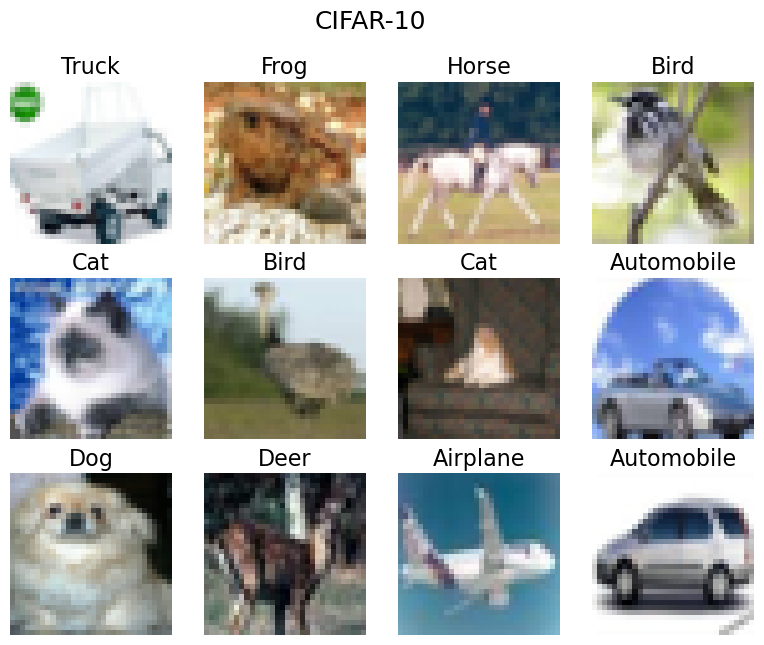

In [10]:
# Vamos a visualizar un subconjunto de las imagenes que hemos cargado
clases = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt.figure(figsize=(9.6,7.2))
plt.suptitle("CIFAR-10", size=18)
plt.subplots_adjust(wspace=0.2)

pos = 1
for n in np.random.randint(low=0,high=len(X_train),size=12):
    plt.subplot(3, 4, pos)
    plt.imshow(X_train[n])
    plt.axis('off')
    plt.title(clases[Y_train[n][0]], size=16)
    pos += 1
plt.show()

Revisamos la distribución de cada clase. En CIFAR-10 la cantidad de imágenes por clases están equilibradas, pero aún así es un ejercicio apropiado confirmar esta separación, ya que además hemos subdividido el conjunto de entrenamiento en entrenamiento y validación.

In [11]:
class_names = dict(zip(range(0, 10), clases))

In [12]:
print('Recuento entrenamiento')
labels, counts = np.unique(Y_train, return_counts=True)
for label, count in zip(labels, counts):
    print(f"{class_names[label]}: {count}")

Recuento entrenamiento
Airplane: 4000
Automobile: 4000
Bird: 4000
Cat: 4000
Deer: 4000
Dog: 4000
Frog: 4000
Horse: 4000
Ship: 4000
Truck: 4000


In [13]:
print('Recuento validación')
labels, counts = np.unique(Y_valid, return_counts=True)
for label, count in zip(labels, counts):
    print(f"{class_names[label]}: {count}")

Recuento validación
Airplane: 1000
Automobile: 1000
Bird: 1000
Cat: 1000
Deer: 1000
Dog: 1000
Frog: 1000
Horse: 1000
Ship: 1000
Truck: 1000


In [14]:
print('Recuento test')
labels, counts = np.unique(Y_test, return_counts=True)
for label, count in zip(labels, counts):
    print(f"{class_names[label]}: {count}")

Recuento test
Airplane: 1000
Automobile: 1000
Bird: 1000
Cat: 1000
Deer: 1000
Dog: 1000
Frog: 1000
Horse: 1000
Ship: 1000
Truck: 1000


Queremos añadir una capa de data_augmentation. Vamos a definirla y a comprobar primero sus efectos.

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomRotation(factor=0.05),
    tf.keras.layers.RandomContrast(factor=0.5, value_range=(0, 1)) #rango 0 a 1 porque tenemos valores normalizados
], name="data_augmentation")

I0000 00:00:1751793032.808362     946 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:0b:00.0, compute capability: 8.9


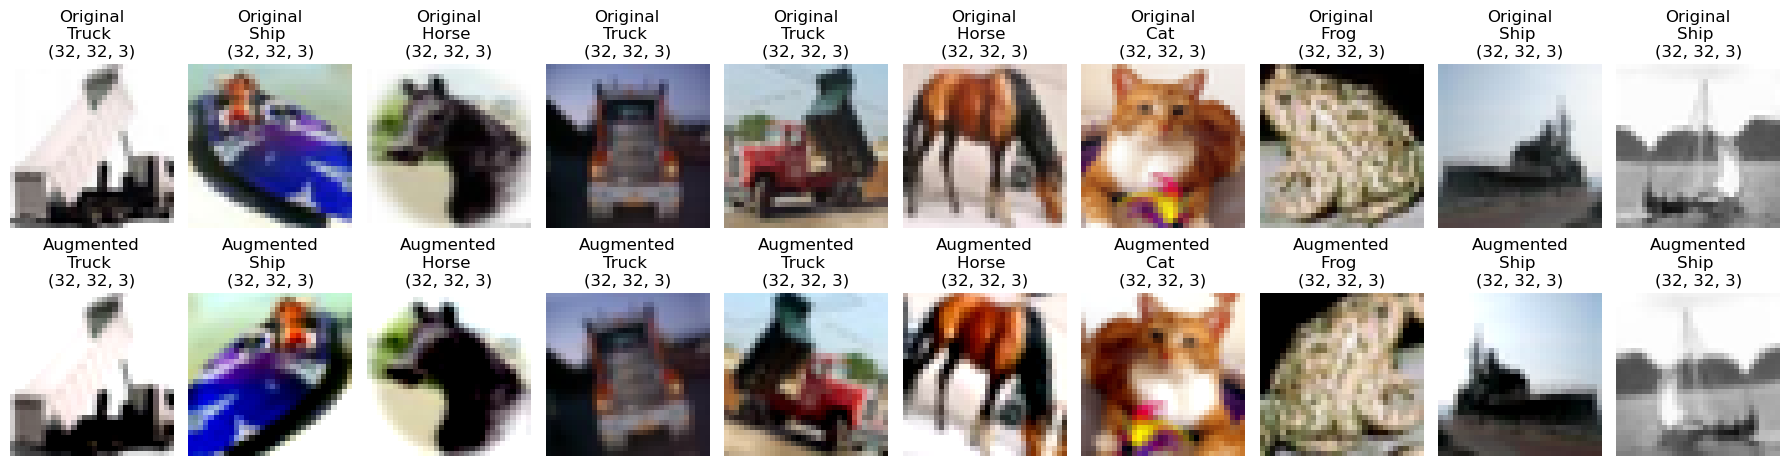

In [16]:
# Selecciona algunas imágenes para mostrar
num_images = 10
images = X_train[:num_images]
labels = Y_train[:num_images]

# Aplica augmentación (training=True para que actúe)
augmented_images = data_augmentation(images, training=True)


# Visualiza
plt.figure(figsize=(18, 5))
for i in range(num_images):
    # Imagen original
    plt.subplot(2, num_images, i + 1)
    plt.imshow(images[i])
    plt.title(f"Original\n{class_names[labels[i][0]]} \n{images[i].shape}")
    plt.axis("off")

    # Imagen aumentada
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(augmented_images[i])
    plt.title(f"Augmented\n{class_names[labels[i][0]]} \n{augmented_images[i].shape}")
    plt.axis("off")

plt.tight_layout()
plt.show()

El redimensionamiento de las imágenes se hará dentro de la pipeline para optimizar el uso de RAM. Por lo general, ha sido difícil obtener resultados con mi gpu que me permite usar tamaños superiores a 96x96

# 2. Descripción y obtención de resultados de diferentes modelos.

Se realizará los ejercicios correspondientes a los 3 modelos señalizados en el enunciado de la actividad. El primer modelo consiste en construir de cero una red convolucional para la tarea de clasificación. El segundo se trataría de aplicar un primer paso del transfer learning usando un modelo preentrenado para adaptarlo a nuestro dataset, usándolo como feature extractor. En tercer lugar, se realziarían ajustes de fine tuning sobre el modelo 2 descongelando capas del modelo para su entrenamiento.

En primer lugar vamos a definir funciones necesarias para realizar tareas de early stopping, adaptación del learning rate, visualización de precisión y loss y recuperación de mejor modelo, así como guardar estos datos.

In [17]:
#definimos una clase para guardar los learning rates y usar callbacks para obtener los mejores parámetros
K = tf.keras.backend

# Callback personalizado
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.losses.append(logs.get("loss", None))

        # Obtener el valor de learning_rate y asegurarnos de que sea un número
        lr = self.model.optimizer.learning_rate
        #if not isinstance(lr, tf.Variable):
        #    lr = lr.numpy()  # Convertir a valor numérico si es un tf.Variable

        # Registrar la tasa de aprendizaje
        #self.rates.append(lr)
        self.rates.append(float(K.get_value(self.model.optimizer.learning_rate)))

        # Actualizar el learning rate
        if isinstance(float(K.get_value(self.model.optimizer.learning_rate)), (float, int)):
            new_lr = float(K.get_value(self.model.optimizer.learning_rate)) * self.factor
            self.model.optimizer.learning_rate.assign(new_lr)  # Modificar learning_rate

In [18]:
"""K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        old_rate = self.model.optimizer.learning_rate
        new_rate = old_rate * self.factor
        new_rate = new_rate.numpy()
        self.model.optimizer.learning_rate.assign(new_rate)  # Modificar learning_rate
        #K.set_value(old_rate, new_rate)"""

"""class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate
        self.rates.append(lr.numpy())
        self.losses.append(logs.get("loss", None))
        lr.assign(lr * self.factor)"""

'class ExponentialLearningRate(tf.keras.callbacks.Callback):\n    def __init__(self, factor):\n        super().__init__()\n        self.factor = factor\n        self.rates = []\n        self.losses = []\n\n    def on_batch_end(self, batch, logs=None):\n        lr = self.model.optimizer.learning_rate\n        self.rates.append(lr.numpy())\n        self.losses.append(logs.get("loss", None))\n        lr.assign(lr * self.factor)'

In [19]:
def plot_loss_save(history, directory, best_epoch, best_values, model_name):
    loss = history.history["loss"]            # Pérdida en entrenamiento
    val_loss = history.history["val_loss"]    # Pérdida en validación

    epochs = range(1, len(loss) + 1)  # Lista de epochs

    # Graficar la pérdida
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, "b-", label="Training Loss")
    plt.plot(epochs, val_loss, "r--", label="Validation Loss")
    plt.plot(best_epoch, best_values[0], "p", label="Best Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Evolución de la función de pérdida, test accuracy best model {}".format(best_values[1]))
    plt.legend()
    
    plt.savefig("{}/loss_entrenamiento_{}.png".format(directory, model_name), dpi=300)
    plt.close()
    return None

In [20]:
def plot_precision(history, directory, model_name):
    plt.figure()
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.xlabel('Epoch')
    plt.ylabel('Precisión')
    plt.title('Precisión durante el entrenamiento, {}'.format(model_name))
    plt.legend()
    plt.grid(True)
    plt.savefig("{}/precision_entrenamiento_{}.png".format(directory, model_name), dpi=300)
    plt.close()  # para no mostrar en el notebook
    return None

In [21]:
def plot_loss(expon_lr, model_name): #usaremos este para selección de learning rate
    rates = np.array(expon_lr.rates)
    losses = np.array(expon_lr.losses)
    rates = rates.flatten()
    losses = losses.flatten()
    plt.plot(rates, losses, label = model_name)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    #plt.axis([min(rates), max(rates)+10, 2.1, 2.4])
    plt.grid()
    plt.legend()
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    return None

## Modelo 1.

CNN de línea base. Construirlo de cero buscando una buena convergencia y resultado métrico. Añade las capas necesarias y justifica su resultado empíricamente.

In [22]:
#vamos a crear un directorio para guardar diferentes resultados del modelo
os.makedirs('Modelo1', exist_ok=True)

In [23]:
input_shape = X_train[0].shape #resolución de las imágenes de entrada
output_shape = 10 #tenemos 10 dígitos

De primeras, vamos a probar con un modelo similar al expuesto en el capítulo 14 de Hands-On Machine Learning with Scikit-Learn, Keras and tensorflow
https://learning.oreilly.com/library/view/hands-on-machine-learning/9781098125967/ch14.html#id258

La arquitectura básica resulta tras una capa inicial de convolución más maxPooling, se añaden dos de convolución con una de max pooling. A continuación se ponen varias capas densas hasta la de salida, añadiendo dropout. A diferencia de Fashion MNIST tenemos tres canales de color y no sólo uno. Conservamos el uso ed MaxPooling, que permite hacer un uso más exagerado de características de los bordes (si usaramos average podríamos suavizar mucho y en imágenes tan pequeñas perder toda la información) y un kernel pequeño por razones similares. Usamos padding same porque las imágenes son muy pequeñas y con la adición de cada capa convlutiva podríamos acabar por perder toda la imagen y no tener la posibilidad de extraer estructuras más complejas.

In [24]:

def create_model(initial_layer = 32, hidden_layers_neurons = [32, 64], value_learning_rate = 1e-3, growing_factor = 1.01, kernel_size = [3, 3], img_size = 32, augmented = False):
    tf.keras.backend.clear_session() #clear session para evitar empezar con pesos o configuraciones de anteriores runs
    
    resize_layer = tf.keras.layers.Resizing(
    height=img_size,
    width=img_size)


    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    
    if img_size != 32: #estamos usando CIFAR-10, sabemos que siempre tendremos por defecto un tamaño de 32x32
        x = resize_layer(x)
    if augmented:
        x = data_augmentation(x)


    x = keras.layers.Conv2D(initial_layer, (kernel_size[0], kernel_size[0]), activation = 'relu', padding = 'same')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x)
    
    for i in range(len(hidden_layers_neurons)):
        neurons = hidden_layers_neurons[i]
        x = keras.layers.Conv2D(neurons, (kernel_size[1], kernel_size[1]), activation = 'relu', padding = 'same')(x)
        x = keras.layers.Conv2D(neurons, (kernel_size[1], kernel_size[1]), activation = 'relu', padding = 'same')(x)
        x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x)
    
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation = 'relu',
                          kernel_initializer="he_normal")(x)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(output_shape, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=output) 

    optimizer = tf.keras.optimizers.SGD(learning_rate = value_learning_rate)
    model.compile(loss = "sparse_categorical_crossentropy", 
                  optimizer = optimizer,
                  metrics = ["accuracy"])
    expon_lr = ExponentialLearningRate(factor = growing_factor)
    return model, expon_lr

En primer lugar, vamos a probar como cambia el modelo con diferentes tamaños de imágenes. Al tener más píxeles debería poder obtener más información y extraer más, pero se hará mucho más pesado el modelo

In [25]:
img_sizes = [32, 
             64, 96
             ]
initial_layer=64
hidden_layers_neurons = [256, 128]
value_learning_rate = 6e-3
kernel_size = [7, 3]
augmented = False
batch_size = 64

In [26]:
histories = []
learningRates = []
for img_size in img_sizes:
    model, expon_lr = create_model(initial_layer=initial_layer, hidden_layers_neurons = hidden_layers_neurons, value_learning_rate = value_learning_rate, kernel_size = kernel_size, augmented = False, img_size=img_size)
    history = model.fit(X_train, Y_train, 
                            epochs = 1,
                            validation_data = (X_valid, Y_valid),
                            callbacks = [expon_lr], batch_size = batch_size)
    histories.append(history)
    learningRates.append(expon_lr)

I0000 00:00:1751793037.739358    1073 service.cc:148] XLA service 0x7e6bd0004930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751793037.739406    1073 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-07-06 10:10:37.777449: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751793037.865577    1073 cuda_dnn.cc:529] Loaded cuDNN version 91001
2025-07-06 10:10:38.848248: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_763', 96 bytes spill stores, 96 bytes spill loads

2025-07-06 10:10:38.867619: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_763', 96 bytes s

 13/625 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.0950 - loss: 2.3066

I0000 00:00:1751793042.292621    1073 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.1245 - loss: 2.2875 - val_accuracy: 0.1000 - val_loss: 2.3165


2025-07-06 10:10:56.393378: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_852', 96 bytes spill stores, 96 bytes spill loads

2025-07-06 10:10:56.413506: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_852', 96 bytes spill stores, 96 bytes spill loads

2025-07-06 10:10:56.414149: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_852', 24 bytes spill stores, 24 bytes spill loads

2025-07-06 10:10:56.418904: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_852', 48 bytes spill stores, 48 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.1295 - loss: 2.2845 - val_accuracy: 0.1000 - val_loss: 2.3165


2025-07-06 10:11:35.153681: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_852', 96 bytes spill stores, 96 bytes spill loads

2025-07-06 10:11:35.187018: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_852', 96 bytes spill stores, 96 bytes spill loads

2025-07-06 10:11:35.201748: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_852', 24 bytes spill stores, 24 bytes spill loads

2025-07-06 10:11:35.272789: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_852', 48 bytes spill stores, 48 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 102ms/step - accuracy: 0.1334 - loss: 2.2880 - val_accuracy: 0.1000 - val_loss: 2.3165


In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,550,604 (13.54 MB)

 Trainable params: 3,550,602 (13.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

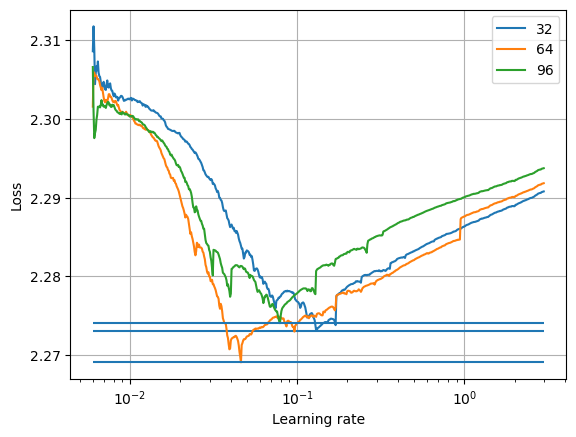

In [28]:
for i, j in zip(learningRates, img_sizes):
    plot_loss(i, str(j))

In [29]:
from pathlib import Path
import time

In [30]:

learning_rates = [8e-2, 5e-2, 5e-2
                ]
histories = []
learningRates = []
best_models = []
best_models_score = []
best_epochs = []
val_patience = 4
timing = []
names_list = []
for img_size, value_lr in zip(img_sizes, learning_rates):
    print(img_size, value_lr)
    inicio = time.time()
    model, expon_lr = create_model(initial_layer=initial_layer, hidden_layers_neurons = hidden_layers_neurons, value_learning_rate = value_lr, kernel_size = kernel_size, augmented = False, img_size=img_size)


    name_directory = 'Modelo1'
    name_model = "Modelo1/{}im_size_baseModel.keras".format(str(img_size))
    print(name_model)
    #este código es para guardar los pesos
    run_index = 1 # increment this at every run
    run_logdir = Path() / name_directory / "run_{:03d}".format(run_index)
    run_logdir.mkdir(parents=True, exist_ok=True)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = val_patience) #patience cuanto espero desde que empieza a estabilizarse el loss antes de parar
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(name_model, save_best_only=True) #me quedo el mejor y bye lo demás
    #tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

    history = model.fit(X_train, Y_train, 
                            epochs = 50,
                            validation_data = (X_valid, Y_valid),
                            callbacks = [checkpoint_cb, early_stopping_cb], batch_size = batch_size)
    histories.append(history)
    learningRates.append(expon_lr)

    histories.append(history)
    learningRates.append(expon_lr)

    model = tf.keras.models.load_model(name_model) # rollback to best model
    best_models.append(model)
    score = model.evaluate(X_test, Y_test) #testeamos qué tal queda
    best_models_score.append(score)
    best_epoch = early_stopping_cb.stopped_epoch - early_stopping_cb.patience + 1
    best_epochs.append(best_epoch)

    fin = time.time()
    seconds = fin-inicio
    timing.append(seconds)

    model_name = "{}im_size_baseModel".format(str(img_size))
    names_list.append(model_name)
    #plot_loss_save(expon_lr, best_epoch, name_directory)
    plot_loss_save(history, name_directory, best_epoch, score, model_name)
    plot_precision(history, name_directory, model_name)

32 0.08
Modelo1/32im_size_baseModel.keras
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.1635 - loss: 2.2160 - val_accuracy: 0.2693 - val_loss: 1.9931
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.3467 - loss: 1.7808 - val_accuracy: 0.4582 - val_loss: 1.5109
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4345 - loss: 1.5565 - val_accuracy: 0.4882 - val_loss: 1.4175
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4913 - loss: 1.4061 - val_accuracy: 0.5526 - val_loss: 1.2378
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5399 - loss: 1.2871 - val_accuracy: 0.5957 - val_loss: 1.1428
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5856 - loss: 1.1658 - val_accuracy: 0.6059 - val_loss: 1.1013
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6252 - loss: 1.0606 - val_accuracy: 0.6507 - val_loss: 1.0119
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step -

In [31]:
best_models_score

[[0.9095759987831116, 0.6897000074386597],
 [0.8812751173973083, 0.7038000226020813],
 [0.8967078328132629, 0.6840000152587891]]

Para este caso, no parece que usar imágenes más grandes esté ofreciendo mejores resultados.

In [32]:
print(sum(timing)/60)
print(timing)

21.23364983399709
[121.5892539024353, 412.8056106567383, 739.6241254806519]


Vamos entonces a probar ahora no con diferentes imágenes, sino diferentes combinaciones de capas. Probemos con uno y dos pares de convolucional. Para este caso no hemos vuelto a medir los mejores learning rates, pero la diferencia para estos cambios no suele ser de saltos muy grandes.

In [33]:
learning_rates = [8e-2, 8e-2, 8e-2, 8e-2
                ]
histories = []
learningRates = []
#best_models = []
#best_models_score = []
val_patience = 4
#timing = []

img_size = 32

hidden_layers_neurons = [[128, 64], [256], [128], [64]]
for neuron, value_lr in zip(hidden_layers_neurons, learning_rates):
    print(img_size, value_lr)
    inicio = time.time()
    model, expon_lr = create_model(initial_layer=initial_layer, hidden_layers_neurons = neuron, value_learning_rate = value_lr, kernel_size = kernel_size, augmented = False, img_size=img_size)


    name_directory = 'Modelo1'
    name_model = "Modelo1/{}neurons_size32_baseModel.keras".format(str(neuron))
    print(name_model)
    #este código es para guardar los pesos
    run_index = 1 # increment this at every run
    run_logdir = Path() / name_directory / "run_{:03d}".format(run_index)
    run_logdir.mkdir(parents=True, exist_ok=True)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = val_patience) #patience cuanto espero desde que empieza a estabilizarse el loss antes de parar
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(name_model, save_best_only=True) #me quedo el mejor y bye lo demás
    #tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

    history = model.fit(X_train, Y_train, 
                            epochs = 50,
                            validation_data = (X_valid, Y_valid),
                            callbacks = [checkpoint_cb, early_stopping_cb], batch_size = batch_size)
    histories.append(history)
    learningRates.append(expon_lr)

    histories.append(history)
    learningRates.append(expon_lr)

    model = tf.keras.models.load_model(name_model) # rollback to best model
    best_models.append(model)
    score = model.evaluate(X_test, Y_test) #testeamos qué tal queda
    best_models_score.append(score)
    
    best_epoch = early_stopping_cb.stopped_epoch - early_stopping_cb.patience + 1
    best_epochs.append(best_epoch)
    
    fin = time.time()
    seconds = fin-inicio
    timing.append(seconds)

    model_name = "{}neurons_size32_baseModel".format(str(neuron))
    names_list.append(model_name)
    #plot_loss_save(expon_lr, best_epoch, name_directory)
    plot_loss_save(history, name_directory, best_epoch, score, model_name)
    plot_precision(history, name_directory, model_name)

32 0.08
Modelo1/[128, 64]neurons_size32_baseModel.keras
Epoch 1/50


2025-07-06 10:34:08.565516: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_763', 96 bytes spill stores, 96 bytes spill loads

2025-07-06 10:34:08.588955: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_763', 96 bytes spill stores, 96 bytes spill loads

2025-07-06 10:34:08.616666: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_763', 24 bytes spill stores, 24 bytes spill loads

2025-07-06 10:34:08.726710: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_763', 48 bytes spill stores, 48 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.1749 - loss: 2.1943 - val_accuracy: 0.3557 - val_loss: 1.8151
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3695 - loss: 1.7330 - val_accuracy: 0.4187 - val_loss: 1.6081
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4424 - loss: 1.5332 - val_accuracy: 0.4949 - val_loss: 1.3985
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4915 - loss: 1.4076 - val_accuracy: 0.5225 - val_loss: 1.3181
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5358 - loss: 1.2988 - val_accuracy: 0.5845 - val_loss: 1.1811
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5726 - loss: 1.1957 - val_accuracy: 0.5986 - val_loss: 1.1353
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6062 - loss: 1.1094 - val_accuracy: 0.6268 - val_loss: 1.0696
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6348 - loss: 1.0417 - val_accuracy: 0.6297 - val

2025-07-06 10:35:31.322785: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_685', 96 bytes spill stores, 96 bytes spill loads

2025-07-06 10:35:31.324300: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_685', 96 bytes spill stores, 96 bytes spill loads

2025-07-06 10:35:31.355549: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_685', 24 bytes spill stores, 24 bytes spill loads

2025-07-06 10:35:31.439710: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_685', 48 bytes spill stores, 48 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.2023 - loss: 2.1576 - val_accuracy: 0.3855 - val_loss: 1.6856
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4030 - loss: 1.6525 - val_accuracy: 0.5009 - val_loss: 1.3767
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4873 - loss: 1.4294 - val_accuracy: 0.5602 - val_loss: 1.2420
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5440 - loss: 1.2794 - val_accuracy: 0.6133 - val_loss: 1.1111
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5930 - loss: 1.1537 - val_accuracy: 0.6199 - val_loss: 1.0879
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6273 - loss: 1.0494 - val_accuracy: 0.6534 - val_loss: 0.9841
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6591 - loss: 0.9531 - val_accuracy: 0.6572 - val_loss: 0.9796
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6938 - loss: 0.8665 - val_accuracy: 0.66

2025-07-06 10:38:22.937263: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_685', 96 bytes spill stores, 96 bytes spill loads

2025-07-06 10:38:22.974519: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_685', 24 bytes spill stores, 24 bytes spill loads

2025-07-06 10:38:23.025756: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_685', 96 bytes spill stores, 96 bytes spill loads

2025-07-06 10:38:23.057155: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_685', 48 bytes spill stores, 48 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.1931 - loss: 2.1745 - val_accuracy: 0.4304 - val_loss: 1.6247
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3861 - loss: 1.6950 - val_accuracy: 0.4842 - val_loss: 1.4234
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4622 - loss: 1.4951 - val_accuracy: 0.5037 - val_loss: 1.4148
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5052 - loss: 1.3720 - val_accuracy: 0.5571 - val_loss: 1.2440
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5478 - loss: 1.2704 - val_accuracy: 0.5958 - val_loss: 1.1710
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5745 - loss: 1.1890 - val_accuracy: 0.6124 - val_loss: 1.1105
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6043 - loss: 1.1037 - val_accuracy: 0.6170 - val_loss: 1.1049
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6261 - loss: 1.0442 - val_accuracy: 0.6324 - val_

In [34]:
best_models_score

[[0.9095759987831116, 0.6897000074386597],
 [0.8812751173973083, 0.7038000226020813],
 [0.8967078328132629, 0.6840000152587891],
 [0.9442216753959656, 0.6833000183105469],
 [0.9351751208305359, 0.6802999973297119],
 [0.9703717827796936, 0.6769000291824341],
 [0.9864696264266968, 0.669700026512146]]

Las diferencias no son tan notables. De hecho parece que una red más sencilla parece que está pillando mejores patrones al menos en test. Aunque los porcentajes son tan sutiles que sería necesario realizar más runs y realizar un test estadístico.

La siguiente es el mejor resultado anterior, pero con augmented images. Hay que tener en cuenta, que aunque estamos usando el tamaño más pequeño de las imágenes, quizás la adición de imágenes modificadas podría servirse de mayores tamaños.

In [35]:
img_size = 32
value_lr = 8e-2 #aumentamos un poco el learning rate porque tardaba bastante en converger
neuron = [256, 128]

In [36]:
print(img_size, value_lr)
inicio = time.time()
model, expon_lr = create_model(initial_layer=initial_layer, hidden_layers_neurons = neuron, value_learning_rate = value_lr, kernel_size = kernel_size, augmented = True, img_size=img_size)

name_directory = 'Modelo1'
name_model = "Modelo1/augmented_baseModel.keras"
print(name_model)
#este código es para guardar los pesos
run_index = 1 # increment this at every run
run_logdir = Path() / name_directory / "run_{:03d}".format(run_index)
run_logdir.mkdir(parents=True, exist_ok=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = val_patience) #patience cuanto espero desde que empieza a estabilizarse el loss antes de parar
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(name_model, save_best_only=True) #me quedo el mejor y bye lo demás
#tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, Y_train, 
                            epochs = 50,
                            validation_data = (X_valid, Y_valid),
                            callbacks = [checkpoint_cb, early_stopping_cb], batch_size = batch_size)
histories.append(history)
learningRates.append(expon_lr)

histories.append(history)
learningRates.append(expon_lr)

model = tf.keras.models.load_model(name_model) # rollback to best model
best_models.append(model)
score = model.evaluate(X_test, Y_test) #testeamos qué tal queda
best_models_score.append(score)
best_epoch = early_stopping_cb.stopped_epoch - early_stopping_cb.patience + 1
best_epochs.append(best_epoch)

fin = time.time()
seconds = fin-inicio
timing.append(seconds)

model_name = "augmented_baseModel"
names_list.append(model_name)
#plot_loss_save(expon_lr, best_epoch, name_directory)
plot_loss_save(history, name_directory, best_epoch, score, model_name)
plot_precision(history, name_directory, model_name)

32 0.08
Modelo1/augmented_baseModel.keras
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.1429 - loss: 2.2605 - val_accuracy: 0.2865 - val_loss: 2.0562
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.2967 - loss: 1.9266 - val_accuracy: 0.4165 - val_loss: 1.6044
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.3886 - loss: 1.6810 - val_accuracy: 0.4615 - val_loss: 1.4829
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.4475 - loss: 1.5359 - val_accuracy: 0.4907 - val_loss: 1.4248
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.4832 - loss: 1.4416 - val_accuracy: 0.5425 - val_loss: 1.2784
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5221 - loss: 1.3474 - val_accuracy: 0.5812 - val_loss: 1.1942
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5537 - loss: 1.2545 - val_accuracy: 0.6275 - val_loss: 1.0785
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms

In [37]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,453,452 (5.54 MB)

 Trainable params: 1,453,450 (5.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [38]:
best_models_score

[[0.9095759987831116, 0.6897000074386597],
 [0.8812751173973083, 0.7038000226020813],
 [0.8967078328132629, 0.6840000152587891],
 [0.9442216753959656, 0.6833000183105469],
 [0.9351751208305359, 0.6802999973297119],
 [0.9703717827796936, 0.6769000291824341],
 [0.9864696264266968, 0.669700026512146],
 [0.6790592670440674, 0.7695000171661377]]

In [39]:
df_acc = pd.DataFrame(best_models_score)[[1, 0]].rename({0:'loss', 1:'precision'}, axis = 1)
df_acc['names'] = names_list
df_acc['seconds'] = timing
df_acc['epochs'] = best_epochs
df_acc = df_acc[['names', 'precision', 'loss', 'seconds']]

In [40]:
df_acc

names  precision      loss     seconds
0                32im_size_baseModel     0.6897  0.909576  121.589254
1                64im_size_baseModel     0.7038  0.881275  412.805611
2                96im_size_baseModel     0.6840  0.896708  739.624125
3  [128, 64]neurons_size32_baseModel     0.6833  0.944222   82.432524
4      [256]neurons_size32_baseModel     0.6803  0.935175  104.721585
5      [128]neurons_size32_baseModel     0.6769  0.970372   66.316242
6       [64]neurons_size32_baseModel     0.6697  0.986470   57.257247
7                augmented_baseModel     0.7695  0.679059  344.208182

### Análisis resultados modelo 1

Se han probado diferentes tamaños de imagen para el mismo modelo de CNN, principalmente con el objetivo de evaluar las limitaciones de capacidad de la GPU y determinar cuánto tamaño de imagen es realmente necesario.
Los tamaños utilizados han sido 32x32, 64x64 y 96x96. Como se observa en la tabla anterior, el mejor rendimiento se ha obtenido con el tamaño mediano (64x64), pero no dista mucho del más pequeño (32×32), de un 70,63 a un 69,68%. Es posible que, al tratarse de imágenes originalmente pequeñas, aumentar su tamaño no aporte información adicional útil, y por tanto no represente una mejora. Por lo que a efectis computacionales, es mejor que nos quedemos con el modelo más sencillo.

A continuación, se han probado algunos modelos de CNN más simples utilizando imágenes de tamaño 32×32. Se ha seguido una estructura basada en pares de capas convolucionales, pasando de dos pares con la mitad de neuronas que el modelo original a modelos con un único par de capas con 256, 128 y 64 filtros, respectivamente.
Los modelos más simples parecen haber ofrecido mejores resultados, lo que sugiere que una mayor complejidad puede inducir overfitting cuando se trabaja con imágenes tan pequeñas. Si bien, el modelo más pequeño de sólo 64 neuronas si parece tener mejor rendimiento que los otros. También es notable con el modelo original, por lo que en este caso nos quedaremos con el modelo original. 

Finalmente, se ha aplicado aumento artificial de datos al mejor modelo, lo que ha supuesto una mejora notable en su rendimiento.

# 2. Transfer learning.

In [41]:
#vamos a crear un directorio para guardar diferentes resultados del modelo
os.makedirs('Modelo2', exist_ok=True)

## Modelo 2.

Aprendizaje por transferencia. Pasos:
1. Elegir un modelo pre-entrenado de Keras Applications y ajustarlo al dataset. 
2. Utilizar el modelo preentrenado como un extractor de características. Eliminamos las capas finales responsables de la clasificación y las reemplazamos con nuevas específicas para nuestra tarea.

En este caso, al estar usando una red preentrenada aunque nuestras imágenes sean pequeñas necesitamos acercarnos lo más posible al tamaño de la imagen original. ResNetV2 es bastante ligero, pero las capacidad actuales de mi ordenador sólo me dejan acercarme a 96x96. Sí que he probado con tamaños más pequeños pero es verdad que a mayor tamaño mejor era la precisión. Un batch_size más pequeño parecía dar problemas con la estabilidad y la precisión y no conseguir buenos resultados, por lo que tampoco estaba esa opción.

En este caso, además hemos tenido que rehacer la línea de data_augmentation porque resnet tiene una entrada de datos entre 0 y 1. Al final igualmente, para poder acceder a las capas correctas de gradcam hubo que rechazar por este momento la modificación de las entradas de datos.

In [42]:

# Data augmentation
data_augmentation_2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomContrast(0.1, value_range=[0, 255]),
], name="data_augmentation")

img_size = 96
resize_layer = tf.keras.layers.Resizing(
    height=img_size,
    width=img_size)

# Input layer
inputs = tf.keras.Input(shape=input_shape)
x = inputs
# Augmentation y preprocessing
x = resize_layer(x)
x = data_augmentation_2(x)
x = tf.keras.applications.resnet_v2.preprocess_input(x)

# Base model
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=x)
base_model.trainable = False  # congela pesos

# Clasificación
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
outputs = tf.keras.layers.Dense(output_shape, activation="softmax")(x)

# Modelo final
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [43]:
model.layers[:10]

[<InputLayer name=input_layer_1, built=True>,
 <Resizing name=resizing_1, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <ZeroPadding2D name=conv1_pad, built=True>,
 <Conv2D name=conv1_conv, built=True>,
 <ZeroPadding2D name=pool1_pad, built=True>,
 <MaxPooling2D name=pool1_pool, built=True>,
 <BatchNormalization name=conv2_block1_preact_bn, built=True>,
 <Activation name=conv2_block1_preact_relu, built=True>,
 <Conv2D name=conv2_block1_1_conv, built=True>]

In [44]:
n_epochs = 1
tf.keras.backend.clear_session()

growing_factor = 1.005
expon_lr = ExponentialLearningRate(factor = growing_factor)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"]) #es necesario recompilar cada vez que se congela o descongelan capas
history = model.fit(X_train_raw, Y_train, 
                    validation_data=(X_valid_raw, Y_valid), 
                    epochs=n_epochs, 
                    batch_size = batch_size,
                    callbacks = [expon_lr])

625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.5966 - loss: 1.4979 - val_accuracy: 0.6218 - val_loss: 7.6803


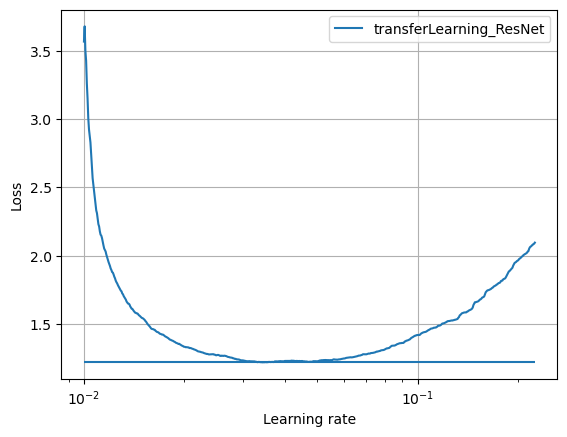

In [45]:
plot_loss(expon_lr, 'transferLearning_ResNet')

In [46]:
n_epochs = 50
val_patience = 3
tf.keras.backend.clear_session()
inicio = time.time()

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"]) #es necesario recompilar cada vez que se congela o descongelan capas

name_model = "Modelo2/transfer_learning.keras"
print(name_model)
#este código es para guardar los pesos
run_index = 1 
run_logdir = Path() / name_directory / "run_{:03d}".format(run_index)
run_logdir.mkdir(parents=True, exist_ok=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = val_patience) #patience cuanto espero desde que empieza a estabilizarse el loss antes de parar
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(name_model, save_best_only=True) #me quedo el mejor y bye lo demás
history = model.fit(X_train_raw, Y_train, 
                    validation_data=(X_valid_raw, Y_valid), 
                    epochs=n_epochs, 
                    batch_size = batch_size,
                    callbacks = [early_stopping_cb, checkpoint_cb])

model = tf.keras.models.load_model(name_model) # rollback to best model
best_models.append(model)
bests = model.evaluate(X_test_raw, Y_test)
names_list.append('transfer_learning')
best_models_score.append(bests)

best_epoch = early_stopping_cb.stopped_epoch - early_stopping_cb.patience + 1
best_epochs.append(best_epoch)

fin = time.time()
seconds = fin-inicio
timing.append(seconds)
plot_loss_save(history, 'Modelo2', best_epoch, score, 'transfer_learning')

Modelo2/transfer_learning.keras
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.7079 - loss: 3.3634 - val_accuracy: 0.7710 - val_loss: 1.7576
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.7471 - loss: 1.7787 - val_accuracy: 0.7810 - val_loss: 1.3238
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.7568 - loss: 1.3600 - val_accuracy: 0.7846 - val_loss: 1.1071
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.7630 - loss: 1.1311 - val_accuracy: 0.7854 - val_loss: 0.9573
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.7676 - loss: 0.9824 - val_accuracy: 0.7881 - val_loss: 0.8779
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.7712 - loss: 0.8998 - val_accuracy: 0.7885 - val_loss: 0.8220
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.7722 - loss: 0.8297 - val_accuracy: 0.7902 - val_loss: 0.7622
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - ac

In [47]:
print(bests) #testeamos qué tal queda

[0.644636869430542, 0.7919999957084656]


La precisión final lograda con el modelo de ResNet no ha sido mucho mayor. 

# Modelo 3. Fine-tuning

In [48]:
# Descongelamos capas
for layer in base_model.layers[-20:]:
    layer.trainable = False

In [49]:
n_epochs_unfrozen = 20
inicio = time.time()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
) #es necesario recompilar al haber descongelado el modelo, pero obviamente no reiniciamos sesión porque estamos realizando tareas de fine-tunning
name_model = "Modelo2/transfer_learnin_fineTuned.keras"
print(name_model)
#este código es para guardar los pesos
run_index = 1 
run_logdir = Path() / name_directory / "run_{:03d}".format(run_index)
run_logdir.mkdir(parents=True, exist_ok=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = val_patience) #patience cuanto espero desde que empieza a estabilizarse el loss antes de parar
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(name_model, save_best_only=True) #me quedo el mejor y bye lo demás
history = model.fit(X_train_raw, Y_train, 
                    validation_data=(X_valid_raw, Y_valid), 
                    epochs=n_epochs_unfrozen, 
                    batch_size = batch_size, 
                    callbacks = [early_stopping_cb, checkpoint_cb])

model = tf.keras.models.load_model(name_model) # rollback to best model
best_models.append(model)

bests = model.evaluate(X_test_raw, Y_test)
names_list.append('transfer_learning_fineTuned')
best_models_score.append(bests)
best_epoch = early_stopping_cb.stopped_epoch - early_stopping_cb.patience + 1
best_epochs.append(best_epoch)

fin = time.time()
seconds = fin-inicio
timing.append(seconds)
plot_loss_save(history, 'Modelo2', best_epoch, score, 'transfer_learning_fineTuned')

Modelo2/transfer_learnin_fineTuned.keras
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.7907 - loss: 0.6278 - val_accuracy: 0.7950 - val_loss: 0.6392
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - accuracy: 0.7908 - loss: 0.6414 - val_accuracy: 0.7978 - val_loss: 0.6293
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.7923 - loss: 0.6344 - val_accuracy: 0.7978 - val_loss: 0.6369
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.7925 - loss: 0.6295 - val_accuracy: 0.7961 - val_loss: 0.6481
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.7936 - loss: 0.6264 - val_accuracy: 0.7951 - val_loss: 0.6508
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7830 - loss: 0.6882


In [50]:
model.evaluate(X_test_raw, Y_test) #testeamos qué tal queda

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7830 - loss: 0.6882


[0.6891065835952759, 0.7853000164031982]

# Análisis críticos de los modelos. 
Condensaremos los resultados de los análisis, comparando los procesos, y posteriormente añadiremos el análisis con grad-cam.
El siguiente código nos permite mostrar una tabña con los modelos utilizadops, la precisión, el loss, los minutos y los epochs para cada uno.

In [ ]:
df_acc = pd.DataFrame(best_models_score)[[1, 0]].rename({0:'loss', 1:'precision'}, axis = 1)
df_acc['names'] = names_list
df_acc['minutes'] = timing
df_acc['minutes'] = df_acc['minutes']*(1/60)
df_acc['epochs'] = best_epochs
df_acc = df_acc[['names', 'precision', 'loss', 'minutes', 'epochs' ]]
df_acc

names  precision      loss    minutes  epochs
0                32im_size_baseModel     0.6897  0.909576   2.026488      11
1                64im_size_baseModel     0.7038  0.881275   6.880094      11
2                96im_size_baseModel     0.6840  0.896708  12.327069       8
3  [128, 64]neurons_size32_baseModel     0.6833  0.944222   1.373875      12
4      [256]neurons_size32_baseModel     0.6803  0.935175   1.745360       9
5      [128]neurons_size32_baseModel     0.6769  0.970372   1.105271      10
6       [64]neurons_size32_baseModel     0.6697  0.986470   0.954287      12
7                augmented_baseModel     0.7695  0.679059   5.736803      23
8                  transfer_learning     0.7920  0.644637  14.258318      23
9        transfer_learning_fineTuned     0.7853  0.689107   2.945269       2

Para añadir algo más de profundidad al estudio, vamos a extraer datos de precisión por clase, para así además poder añadirlos al estadio de gradCAM.

In [53]:
# Separar las imágenes por clase
clases = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
accuracy_dict = {}
loss_dict = {}
best_scores = []

for i in range(len(best_models)):
    X_to_use = X_test
    model_to_use = best_models[i]
    nombre_modelo = names_list[i]
    if 'transfer' in nombre_modelo:
        X_to_use = X_test_raw
    accuracy_dict[nombre_modelo] = {}
    loss_dict[nombre_modelo] = {}
    for clase in range(len(clases)):
        # Obtener las imágenes que pertenecen a la clase 'clase'
        indices_clase = np.where(Y_test == clase)[0]
        score = model_to_use.evaluate(X_to_use[indices_clase], Y_test[indices_clase], verbose = 0)
        loss_dict[nombre_modelo][clases[clase]] = score[0]
        accuracy_dict[nombre_modelo][clases[clase]] = score[1]
    total_score = model_to_use.evaluate(X_to_use, Y_test, verbose = 0)
    best_scores.append(total_score[-1])

# Convertir a DataFrame
df_accuracy = pd.DataFrame(accuracy_dict).T  # Modelos como filas
df_accuracy['conjunto'] = best_scores
df_loss = pd.DataFrame(loss_dict).T

In [54]:
df_accuracy

Airplane  Automobile   Bird    Cat   Deer  \
32im_size_baseModel                   0.781       0.828  0.626  0.552  0.535   
64im_size_baseModel                   0.778       0.792  0.585  0.533  0.636   
96im_size_baseModel                   0.699       0.801  0.574  0.459  0.545   
[128, 64]neurons_size32_baseModel     0.762       0.805  0.548  0.479  0.649   
[256]neurons_size32_baseModel         0.761       0.822  0.578  0.531  0.568   
[128]neurons_size32_baseModel         0.769       0.794  0.494  0.563  0.692   
[64]neurons_size32_baseModel          0.751       0.778  0.510  0.503  0.571   
augmented_baseModel                   0.817       0.884  0.654  0.544  0.772   
transfer_learning                     0.814       0.861  0.715  0.521  0.725   
transfer_learning_fineTuned           0.801       0.817  0.722  0.548  0.736   

                                     Dog   Frog  Horse   Ship  Truck  conjunto  
32im_size_baseModel                0.542  0.740  0.784  0.788  0.721    0.6897  
64im_size_baseModel                0.516  0.841  0.738  0.826  0.793    0.7038  
96im_size_baseModel                0.629  0.809  0.720  0.810  0.794    0.6840  
[128, 64]neurons_size32_baseModel  0.508  0.737  0.746  0.854  0.745    0.6833  
[256]neurons_size32_baseModel      0.551  0.725  0.734  0.811  0.722    0.6803  
[128]neurons_size32_baseModel      0.485  0.700  0.773  0.757  0.742    0.6769  
[64]neurons_size32_baseModel       0.579  0.718  0.768  0.778  0.741    0.6697  
augmented_baseModel                0.650  0.878  0.838  0.822  0.836    0.7695  
transfer_learning                  0.818  0.861  0.766  0.861  0.886    0.7828  
transfer_learning_fineTuned        0.785  0.864  0.789  0.890  0.901    0.7853

In [55]:
df_accuracy.mean().sort_values()

Cat           0.52330
Bird          0.60060
Dog           0.60630
Deer          0.64290
conjunto      0.71253
Horse         0.76560
Airplane      0.77330
Frog          0.78730
Truck         0.78810
Automobile    0.81820
Ship          0.81970
dtype: float64

## Precisión y loss

### Modelo 1

En el Modelo 1, los mejores resultados se han obtenido con la red que comienza con una capa convolucional de 64 filtros, seguida de un par de bloques con 256 filtros + MaxPooling, y otro par con 128 filtros + MaxPooling. Ofrece resultados similares a la red con la misma estructura pero con la mitad de filtros, y ligeramente mejores que las estructuras con un solo bloque. Se alcanza aproximadamente un 69% de precisión.
Con el aumento de datos (data augmentation), se llega alredor 77%, lo que representa una mejora de casi un 10%, mientras que los cambios en la estructura o en el tamaño de la imagen apenas generan mejoras del 1–2%. Además, la función de pérdida (loss) es notablemente menor con el aumento de datos.

### Precisión y loss, imágenes de 32x32, 64x64 y 96x96
En general, observando las gráficas de precisión y pérdida, se muestra un comportamiento bastante habitual y estable, se ve claramente los puntos en que comienzan a estabilizarse las trayectorias y la divergencia entre los conjuntos de validación y test. El punto escogido como mejor epoch, utilizando las técnicas automática de early stopping y callbacks, se sitúa en un punto de la divergencia inicial. Podría discutirse si es mejor coger uno en que hayan divergido menos ambos puntos, pero en este punto no debería tener una diferencia excesiva entre ambos epochs y podría ocasionar una elección sesgada. 

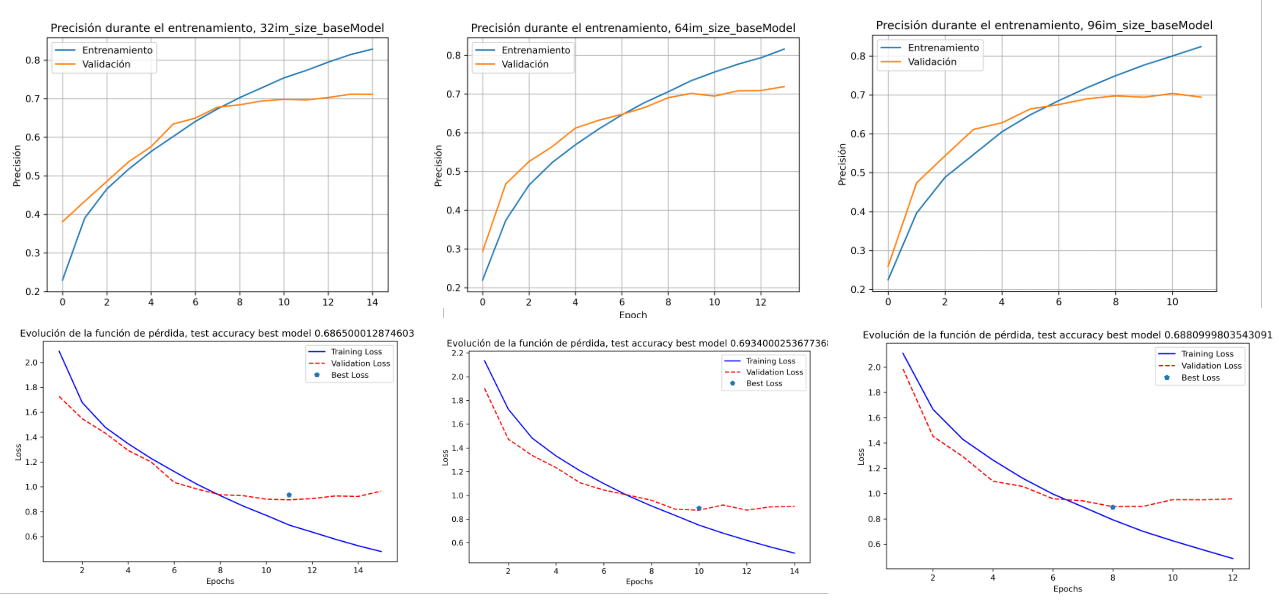

### Precisión y loss, pares de redes neuronales 128-64, 256, 128, 64

En este caso las curvas parecen también estables en general. La divergencia para los casos de menos neuronas y un sólo par de capas diverge mucho antes que para las capas más complejas. Al tener más capas la complejidad es mayor y puede que tome más vueltas alcanzar un límite a los patrones que puede aprender.

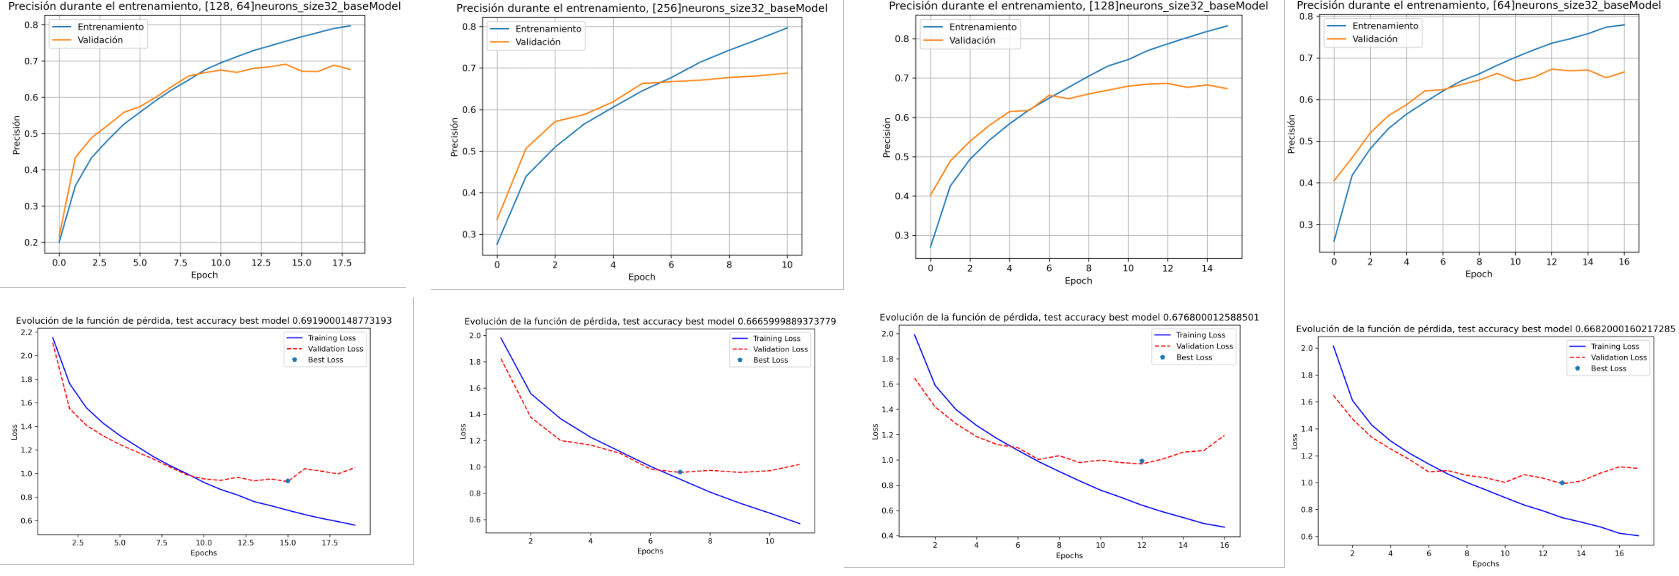

### Precisión y loss, aumento de datos

En este caso lo más notable es que tardó muchos más epochs en convergen, consumiendo bastante más tiempo, aparte del tiempo que necesita la pipeline para realizar las transformaciones a las imágenes. Muy posiblemente se hubiera podido escoger un learning rate más alto que mejora la eficiencia y bajar los 7 minutos que ha tardado.

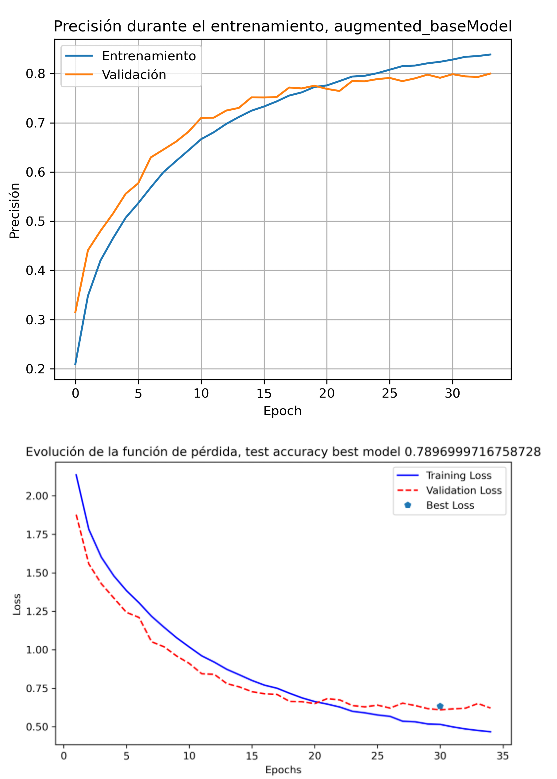


### Modelo 2

En el modelo de transfer learning, se ha utilizado ResNet50V2, que según la documentación de Keras alcanza un 76% de precisión top-1 en ImageNet.
Para nuestro dataset de imágenes diminutas, hemos logrado superar esa precisión con una red mucho más sencilla, manteniendo además tamaños pequeños de imagen.
<br>Durante el entrenamiento, y teniendo en cuenta que se ha aumentado la variabilidad mediante transformaciones, se ha alcanzado un porcentaje aún mayor, del 79,54%, utilizando únicamente la red como extractor de características (feature extractor), aunque el tiempo de entrenamiento ha sido considerablemente mayor.

En el caso del fine-tuning del modelo anterior, los resultados parecen haber empeorado: la precisión ha disminuido y la pérdida ha aumentado respecto a modelos anteriores. Es posible que se haya sobreentrenado el modelo, cruzando el umbral del overfitting.
Podría ser necesario congelar más capas o detener el entrenamiento antes para evitar que se pierda la capacidad de generalización que se obtiene en la etapa de extracción de características.


### Análisis de precisión por clase.

Viendo los valores medio en general de todos los modelos que hemos hecho, parece que automóvil es el que mejor precisión tiene y el peor gato, pájaro y perro. De hecho, parece ser más díficil la predicción de animales. Podría deberse a los contextos en que se ve cada elemento, añadiendo patrones más allá del propio elemento, las característica más naturales de los animales frente a las más diseñadas de los elementos de origen artificial (pues llevan un diseño). Es posible que observando el resalte de gradcam, obtengamos algo más de información en este tema, viendo que clase de características se resaltan.

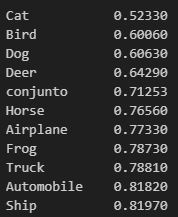

Al mirar por modelo y clase, es interesante ver como el aumento de datos ayudó a todas las clases a mejorar la precisión.
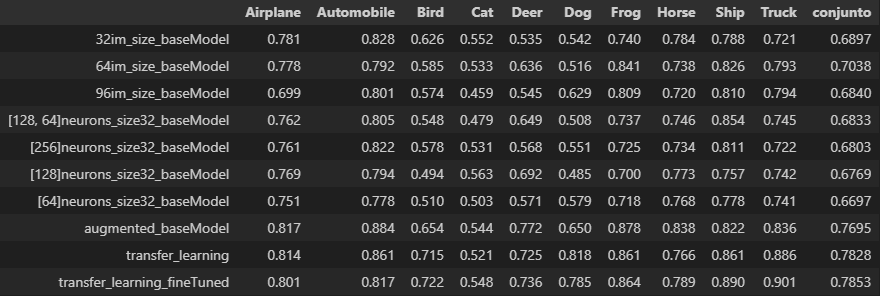




## Batch-size

Se decidió escoger un batch-size de 64, porque la reducción del batch estaba dando peores resultados de precisión, con un aumento del tiempo computacional. Es posible que un menor batch la muestra no tengo un valor estadístico suficiente para aprender bien los patrones, y por lo general no ha dado problemas de convergencia y ha generalizado bien a los conjuntos de validación y test, por lo que tampoco parece que sea demasiado grande.




# Grad-cam implementation

Basado en el tutorial:

https://keras.io/examples/vision/grad_cam/

Lo haremos para el mejor modelo 1 y el resultado de fine-tunning para transfer learning.

In [56]:
# Encuentra el último nombre de capa Conv2D
last_conv_layer_name = None
for layer in model.layers[::-1]:
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

print("Última capa convolucional:", last_conv_layer_name)

model_builder = keras.applications.resnet_v2.ResNet50V2
img_size = X_train[0].shape

Última capa convolucional: conv5_block3_3_conv


In [72]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    print(last_conv_layer_name)
    # Crea el grad_model usando esa capa directamente
    grad_model = tf.keras.Model(
    inputs = model.inputs,
    outputs = [model.get_layer(last_conv_layer_name).output, model.output]
)
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def make_heatmap(X_test_resized, i_image, model, class_names, last_conv_layer_name):
    # Prepare image
    img_array = X_test_resized[i_image] #ya tenemos el test procesado
    #img_array = tf.image.resize(img_array, img_size)
    img_array = np.expand_dims(img_array, axis=0)         # pasa de (224, 224, 3) → (1, 224, 224, 3)  

    """# Make model
    model = model_builder(weights="imagenet")"""

    # Remove last layer's softmax
    #model.layers[-1].activation = None

    # Print what the top predicted class is
    #preds = model.predict({model.layers[0].name: img_array})
    preds = model.predict(img_array)
    # Obtener el índice de la clase con mayor probabilidad
    pred_index = np.argmax(preds)
    accuracy = np.max(preds)
    # Mostrar la clase correspondiente
    print(f"Predicted class: {class_names[pred_index]}")

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Display heatmap
    #plt.matshow(heatmap)
    #plt.show()
    return heatmap, class_names[pred_index], accuracy

def save_and_display_gradcam(X_test, i_image, heatmap, alpha=0.4):
    img = X_test[i_image]
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Display Grad CAM
    #display(Image(cam_path))
    return superimposed_img
    

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
Predicted class: Airplane
conv5_block3_3_conv


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


0 0
1 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted class: Airplane
conv5_block3_3_conv
0 1
1 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted class: Airplane
conv5_block3_3_conv
0 2
1 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted class: Airplane
conv5_block3_3_conv
0 3
1 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted class: Airplane
conv5_block3_3_conv
0 4
1 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted class: Airplane
conv5_block3_3_conv
0 5
1 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted class: Airplane
conv5_block3_3_conv
0 6
1 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted class: Airplane
conv5_block3_3_conv
0 7
1 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted class: Airplane
conv5_block3_3_conv
0 8
1 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted class: Airplane
conv5_block3_3_conv
0 9
1 9
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted class: Automobile
conv5_block3_3_conv
2 0
3 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted class: Truck
conv5_b

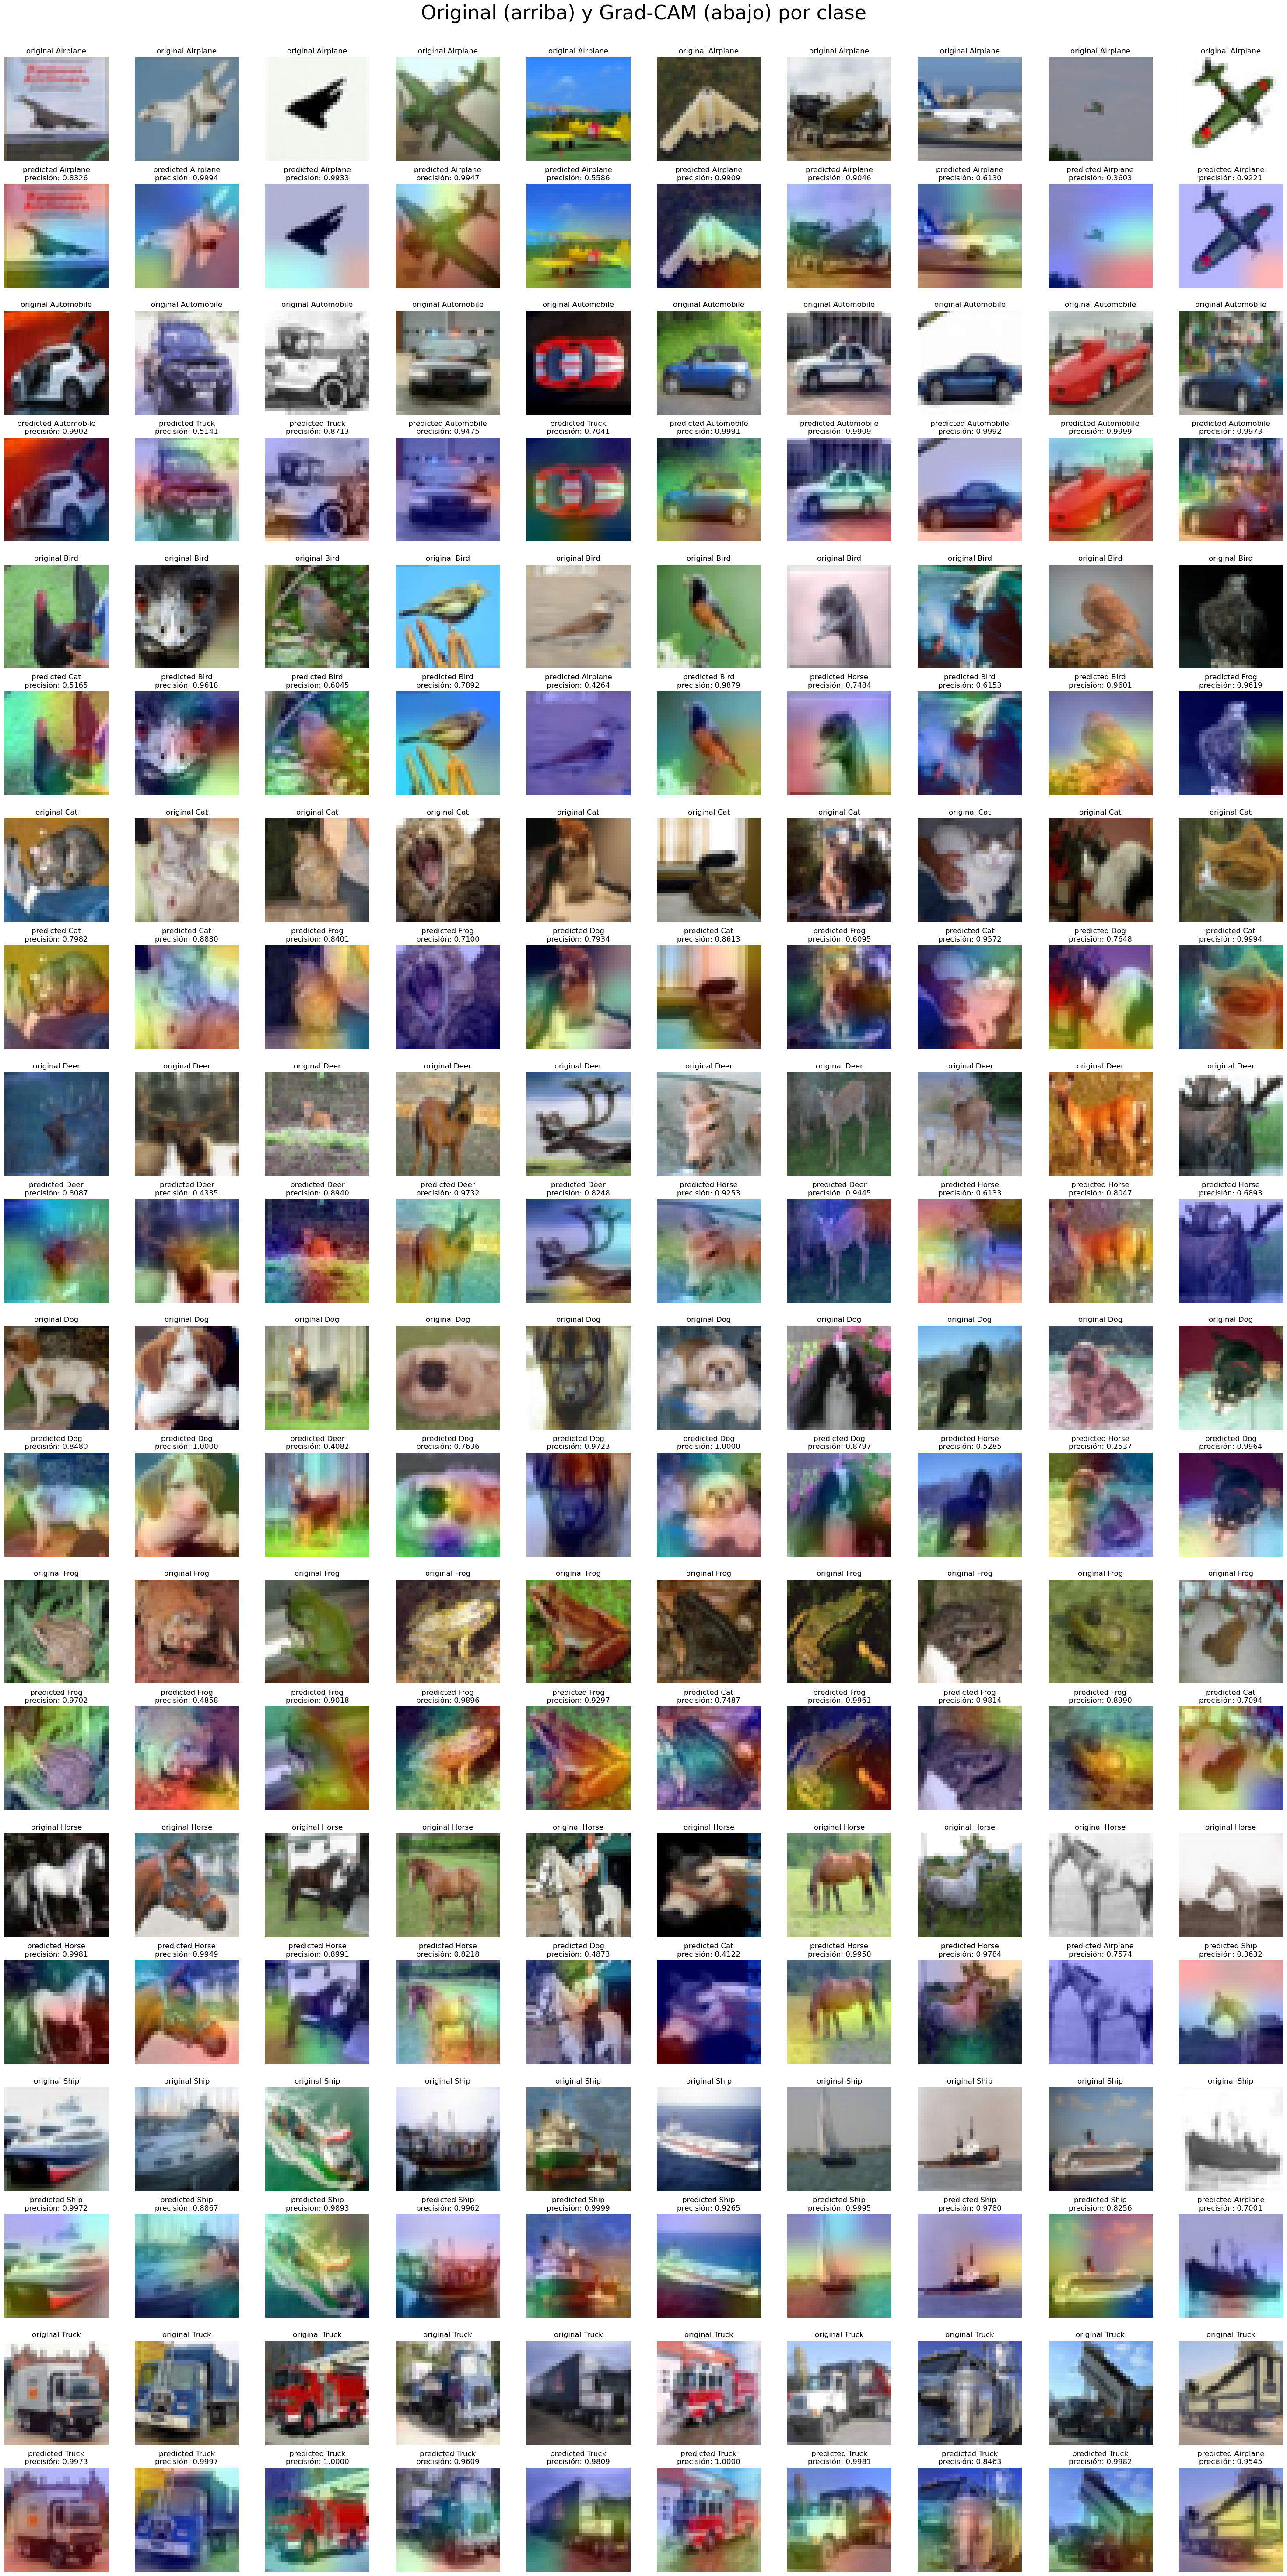

In [73]:
# Separar las imágenes por clase
imagenes_por_clase = {}

for clase in range(len(class_names)):
    #print(clase)
    # Obtener las imágenes que pertenecen a la clase 'clase'
    indices_clase = np.where(Y_test == clase)[0]
    imagenes_por_clase[clase] = indices_clase

# Obtener 10 índices por clase
indices_by_class = imagenes_por_clase

# Crear figura: 20 filas (2 por clase), 10 columnas
fig, axs = plt.subplots(20, 10, figsize=(30, 60))  # Tamaño ajustado
fig.suptitle("Original (arriba) y Grad-CAM (abajo) por clase", fontsize=32)

contador = 0
for class_idx in range(10):
    print(class_idx)
    for i, img_idx in enumerate(indices_by_class[class_idx]):
        if i >= 10:
            break
        original_img = X_test[img_idx]
        heatmap, predicted, accuracy = make_heatmap(X_test_raw, img_idx, model, class_names, last_conv_layer_name)
        superimposed_img = save_and_display_gradcam(X_test_raw, img_idx, heatmap)
        print(class_idx * 2, i)
        print(class_idx * 2 + 1, i)
        # Fila superior: original
        ax_original = axs[class_idx * 2, i]
        ax_original.imshow(original_img)
        ax_original.axis("off")
        ax_original.set_title('original ' + class_names[class_idx])
        if i == 0:
            ax_original.set_ylabel(class_names[class_idx], fontsize=18)

        # Fila inferior: heatmap
        ax_heatmap = axs[class_idx * 2 + 1, i]
        ax_heatmap.imshow(superimposed_img)
        ax_heatmap.axis("off")
        ax_heatmap.set_title('predicted ' + predicted + f'\nprecisión: {accuracy:.4f}')
        contador = contador + 1
        

plt.tight_layout()
plt.subplots_adjust(top=0.96)

# Guardar imagen
plt.savefig("gradcam_Modelo3.png", dpi=300)
plt.show()

In [59]:
df_acc

names  precision      loss    minutes  epochs
0                32im_size_baseModel     0.6897  0.909576   2.026488      11
1                64im_size_baseModel     0.7038  0.881275   6.880094      11
2                96im_size_baseModel     0.6840  0.896708  12.327069       8
3  [128, 64]neurons_size32_baseModel     0.6833  0.944222   1.373875      12
4      [256]neurons_size32_baseModel     0.6803  0.935175   1.745360       9
5      [128]neurons_size32_baseModel     0.6769  0.970372   1.105271      10
6       [64]neurons_size32_baseModel     0.6697  0.986470   0.954287      12
7                augmented_baseModel     0.7695  0.679059   5.736803      23
8                  transfer_learning     0.7920  0.644637  14.258318      23
9        transfer_learning_fineTuned     0.7853  0.689107   2.945269       2

Ahora hacemos lo mismo para el mejor modelo 1, el de datos aumentados.

In [60]:
model_to_use = best_models[7]

In [61]:
model_to_use.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,453,452 (5.54 MB)

 Trainable params: 1,453,450 (5.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [70]:
model_to_use.layers[-6].name

'conv2d_4'

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: Airplane
conv2d_4
0 0
1 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: Airplane
conv2d_4
0 1
1 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class: Airplane
conv2d_4


/home/ruthy/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


0 2
1 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: Airplane
conv2d_4
0 3
1 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: Airplane
conv2d_4
0 4
1 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class: Airplane
conv2d_4
0 5
1 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: Truck
conv2d_4
0 6
1 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: Airplane
conv2d_4
0 7
1 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class: Airplane
conv2d_4
0 8
1 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: Airplane
conv2d_4
0 9
1 9
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class: Automobile
conv2d_4
2 0
3 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class: Truck
conv2d_4
2 1
3 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class: Automobile
conv2d_4
2 2
3 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class: Automobile
conv2d_4
2 3
3 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class: Automobile
conv2d_4
2 4
3 4
1/1 ━━━━━━━━━━━━

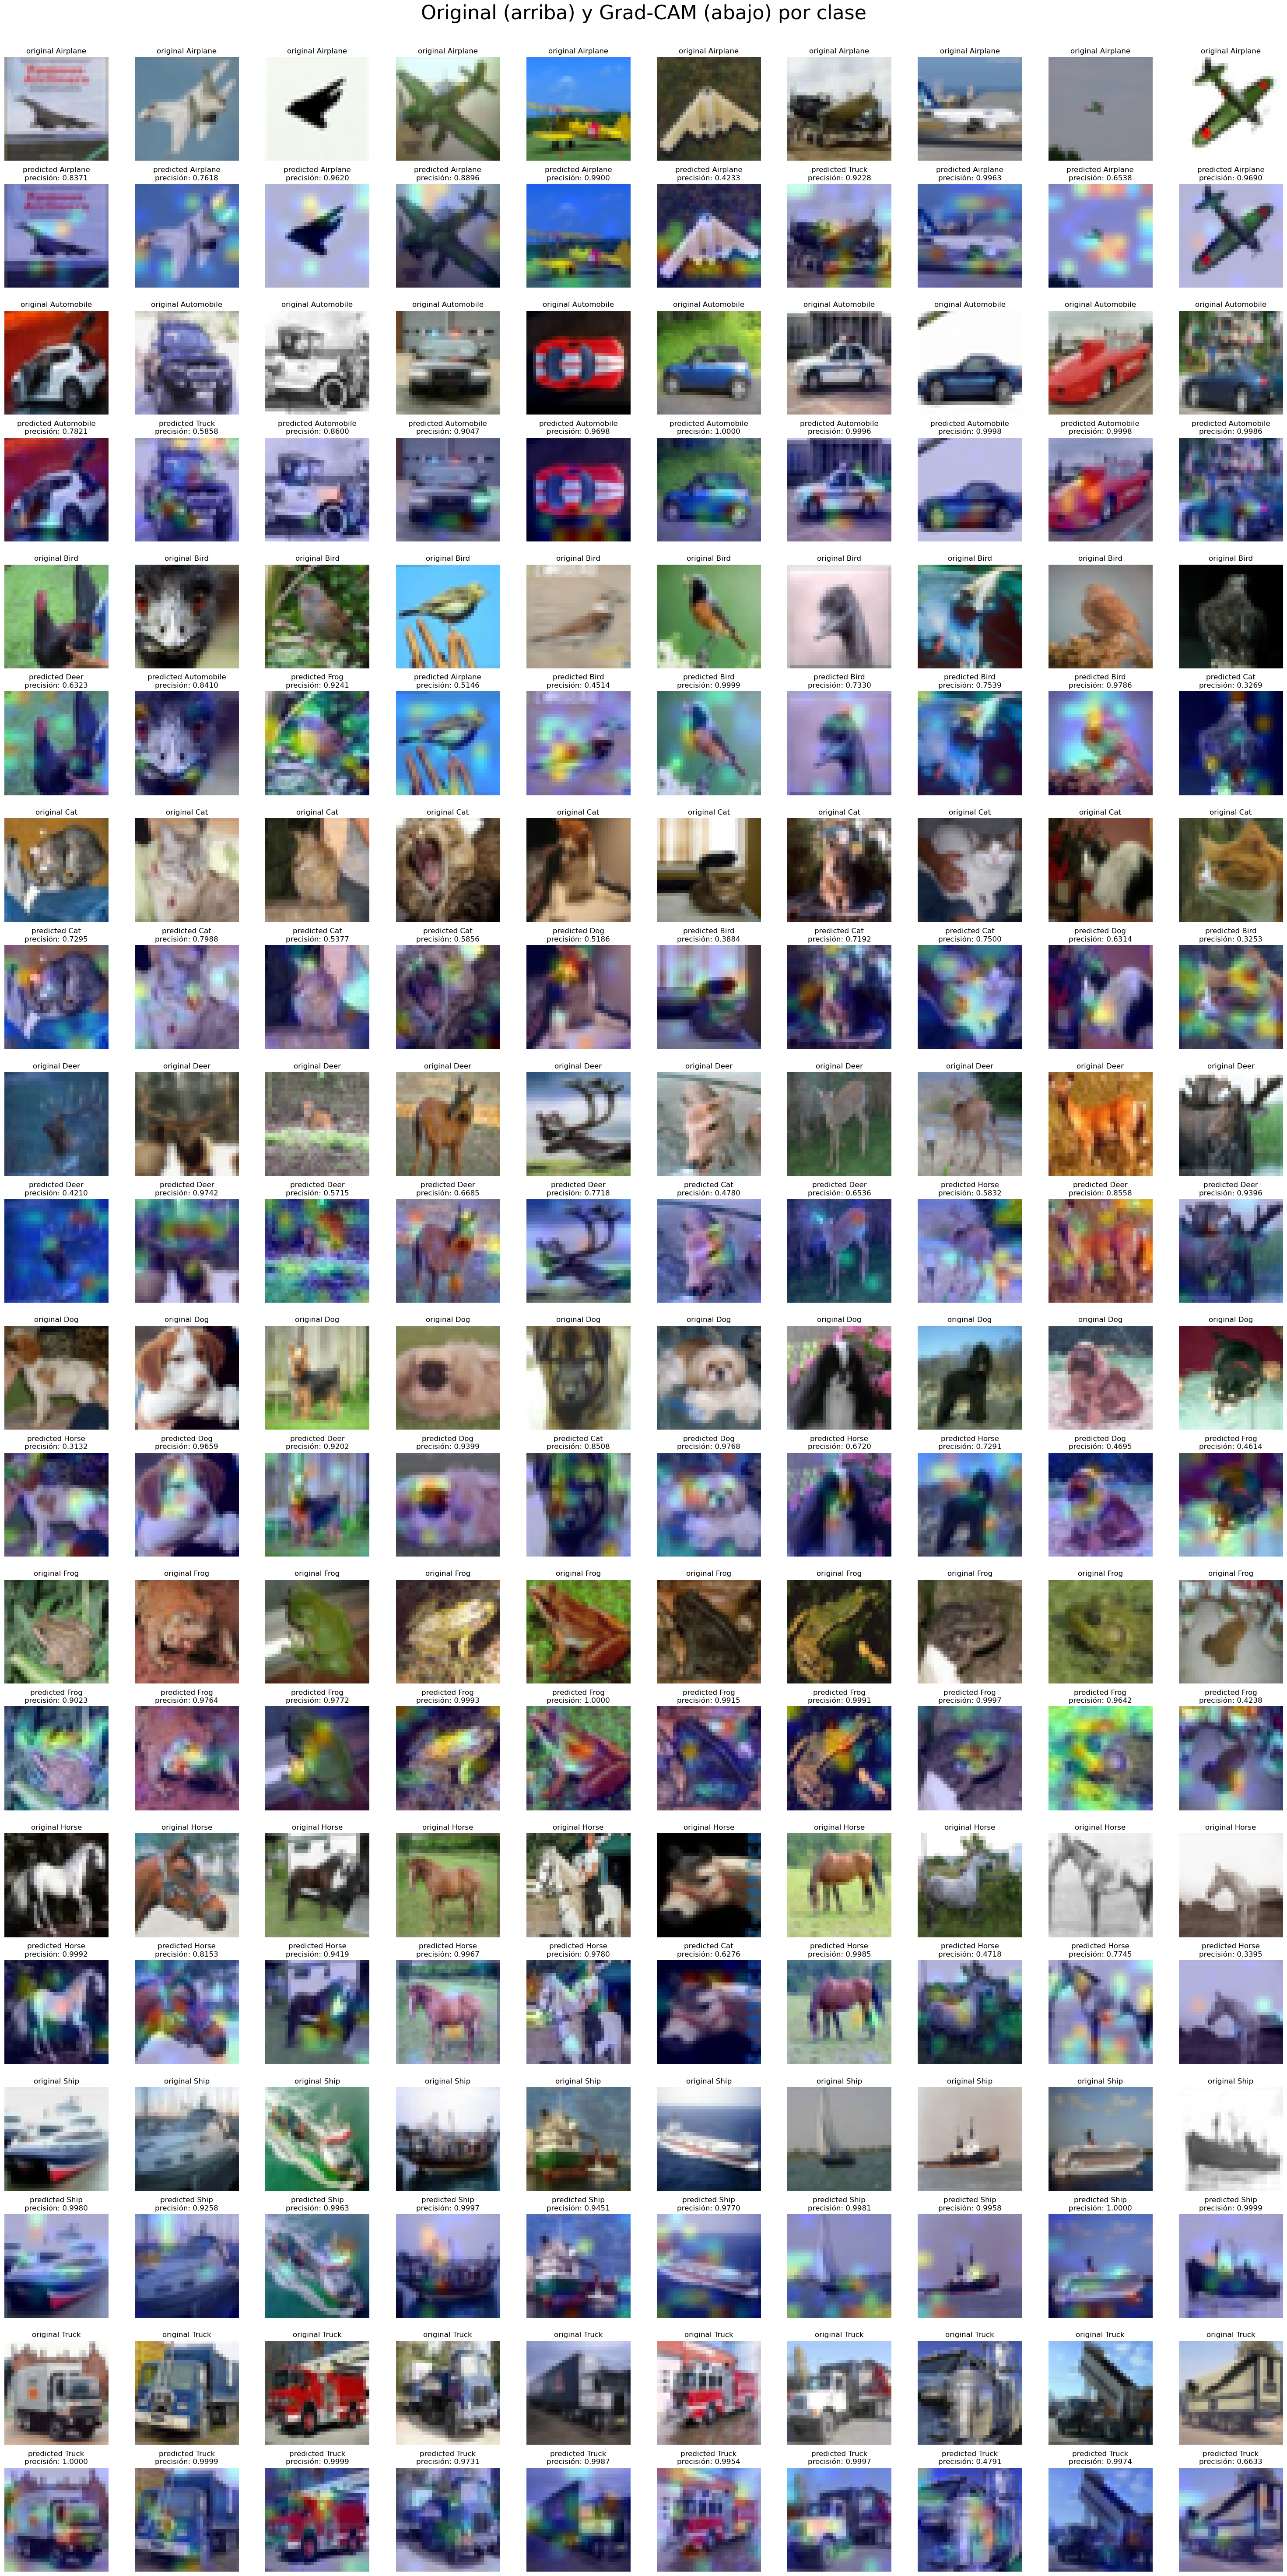

In [75]:
"""if Y_test.ndim > 1:
    Y_test_labels = np.argmax(Y_test, axis=1)
else:
    Y_test_labels = Y_test"""

# Obtener 10 índices por clase
indices_by_class = imagenes_por_clase

# Crear figura: 20 filas (2 por clase), 10 columnas
fig, axs = plt.subplots(20, 10, figsize=(30, 60))  # Tamaño ajustado
fig.suptitle("Original (arriba) y Grad-CAM (abajo) por clase", fontsize=32)

contador = 0
for class_idx in range(10):
    print(class_idx)
    for i, img_idx in enumerate(indices_by_class[class_idx]):
        if i >= 10:
            break
        original_img = X_test[img_idx]
        heatmap, predicted, accuracy = make_heatmap(X_test, img_idx, model_to_use, class_names, 'conv2d_4')
        superimposed_img = save_and_display_gradcam(X_test_raw, img_idx, heatmap)
        print(class_idx * 2, i)
        print(class_idx * 2 + 1, i)
        # Fila superior: original
        ax_original = axs[class_idx * 2, i]
        ax_original.imshow(original_img)
        ax_original.axis("off")
        ax_original.set_title('original ' + class_names[class_idx])
        if i == 0:
            ax_original.set_ylabel(class_names[class_idx], fontsize=18)

        # Fila inferior: heatmap
        ax_heatmap = axs[class_idx * 2 + 1, i]
        ax_heatmap.imshow(superimposed_img)
        ax_heatmap.axis("off")
        ax_heatmap.set_title('predicted ' + predicted + f'\nprecisión: {accuracy:.4f}')
        contador = contador + 1
        

plt.tight_layout()
plt.subplots_adjust(top=0.96)

# Guardar imagen
plt.savefig("gradcam_Modelo1.png", dpi=300)  
plt.show()

# Análisis imágenes grad-cam

De todas las clases que se han mostrado, el caso más interesante me parece el de los pájaros. De 10 imágenes,5 tienen cómo más probable un pájaro, pero una tiene una probabilidad del 45% y 2 a penas pasan del 70%. Frente a este, el resultado del transfer learning tiene acierto en 6 pájaros (la muestra escogida no es aleatoria realmente, he escogido el primer set de 10 en cada categoría), pero no parecen equivocarse en el mismo elemento. Es decir, no predicen lo mismo, y en el resultado del transfer learning está "menos seguro" (la probabilidad es menor) del resultado. La mayoría de elementos que está marcando son contextuales, no está cogiendo elementos que quizás como persona asociaríamos más a un pájaro como ojos, pico y alas.

Resultados modelo 1:
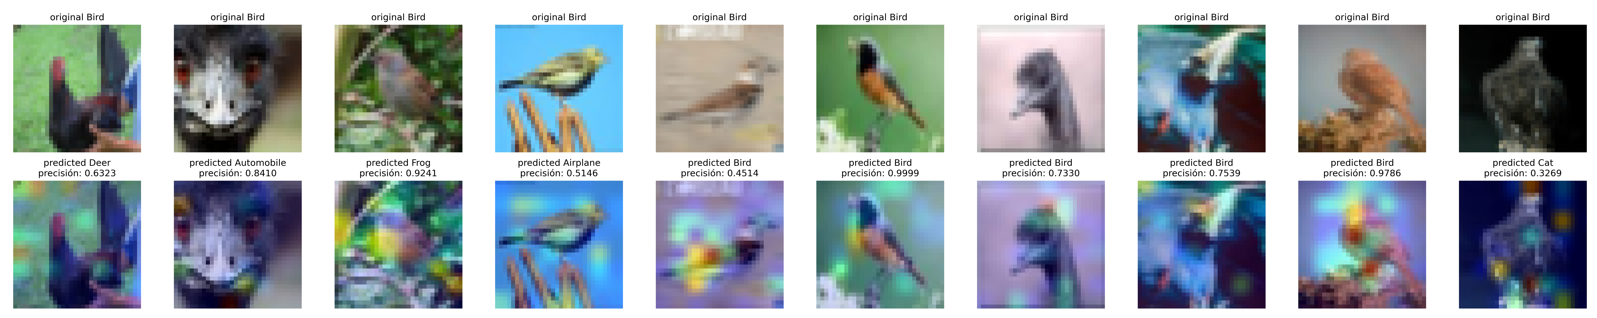

Resultados transfer learning:
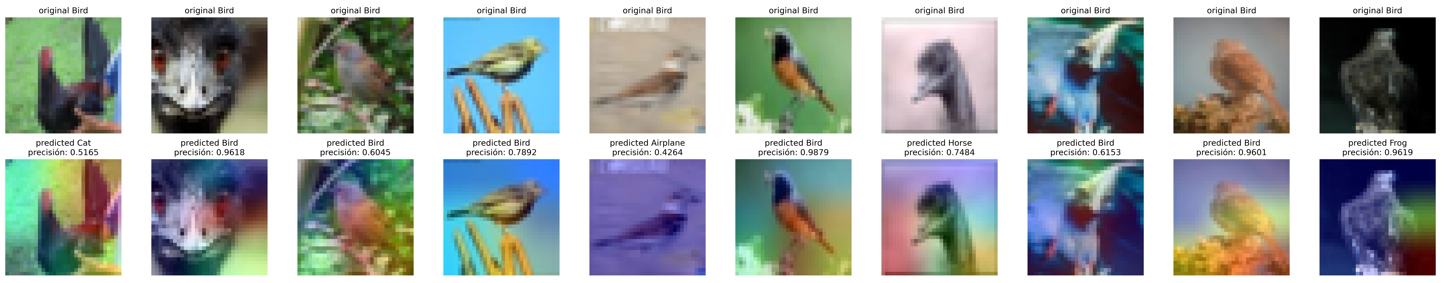

Para el modelo 1, si seguimos observando las imágenes para aviones se sigue viendo que coge muchos elementos contextuales también. En el transfer learning no da información concreta en una zona de la imagen, pero muchas veces resalta información fuera del propio avión.

Si observamos a los coches, en el modelo 1 da muchas veces importancia a la silueta entorno a las ruedas, algo al chasis y parece que a veces a los faro. En un caso de estas la confunde con un camión, que teniendo en cuenta la características a la que da relevancia puede ser natural. En cambio, el modelo de transfer learning da mucho más importancia a la información de forma más extendida en la imagen. ResNet usa capas de average pooling, es posible, sobre todo al ser imágenes tan pequeñas, que MAxPooling sea más efectivo para destacar características en este set debido a suavización que produce el average pooling. En cambios para el modelo 1 parece ocurrir similar pero a la vez coge elementos extraños como carteles en los laterales.

Modelo 1:
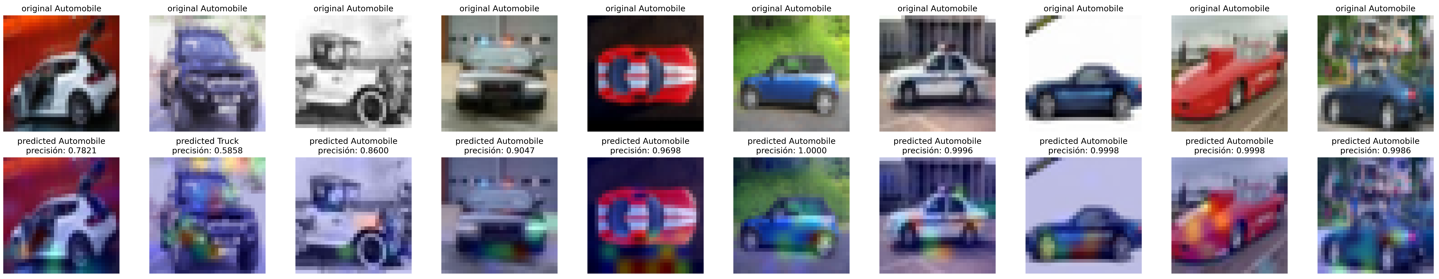

Modelo transfer learning:
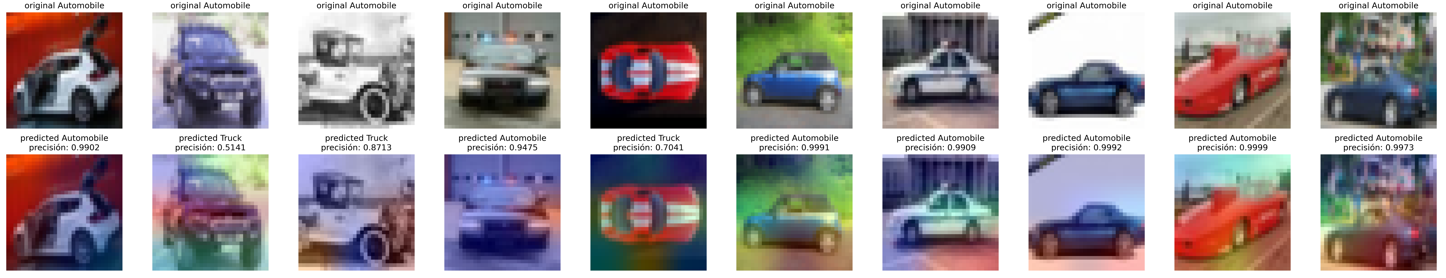

Para el gato, en el modelo 1, sobre todo en imágenes con mejor porcentajes, parece dar importancia a las orejas, el hocico y la cola. En el caso del transfer learning parece señalar más el contexto y la silueta. Para el perro ocurre similar y para la rana parece dar más reelvancia a las vetas que aparecen en su piel en la zona media del cuerpo.

Modelo 1:
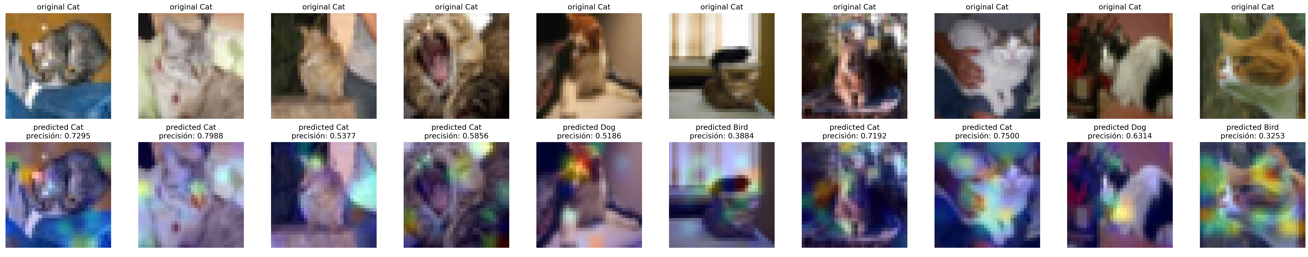

Transfer learning:
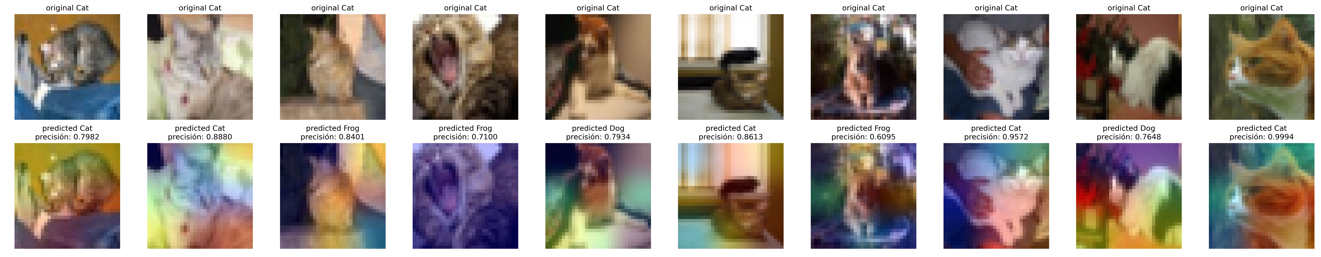

Para el cabalo no tengo claro el análisis, en ambos casos parece resltar a veces elementos como la silueta, las patas o las bridas, pero en otros no, puede que esté intentando aprender más patrones diferenciados para este caso.

Para los barcos, el modelo 1 parece reconocer elementos de la silueta superior o del mar. Parece similar para el transfer learning pero con una zona mayor.

Modelo 1:
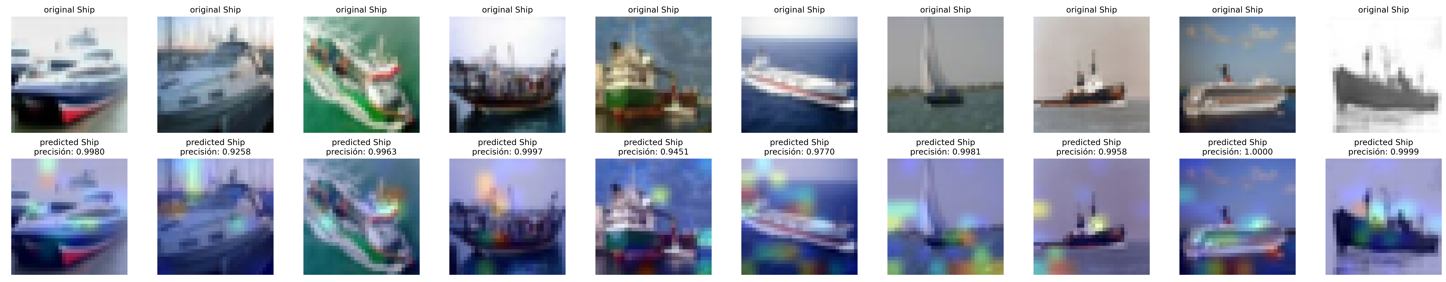

Modelo transfer learning:
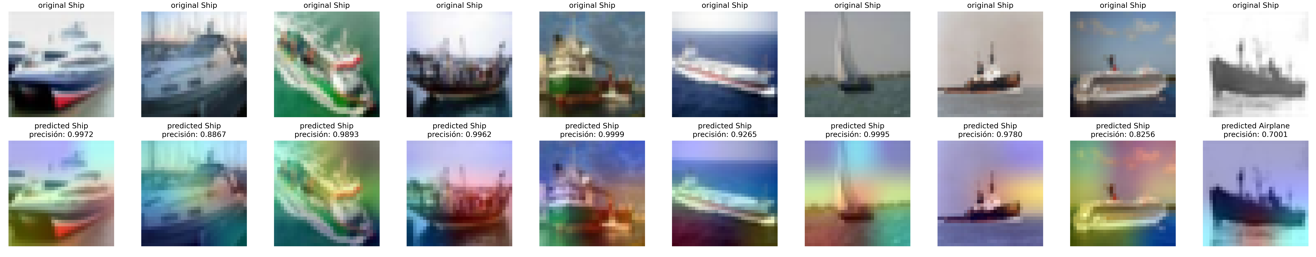


En general, parece que en el modelo 1 ha logrado sacar mejor provecho de características que a lo mejor pertenecen dentro del objeto, como las orejas, el hocico o las ruedas y los faros. Esto podría explicar por qué a pesar de ser un modelo mucho más sencillo entrenado en menos datos, los resultados no son tan diferentes del modelo de transfer learning. El modelo de transfer learning en cambio parece estarle dando mayor relevancia a la silueta general del elemento a clasficar, posiblemente porque realizar las medias haga perder características internas de la silueta.

Los elementos reconocidos de orejas, hocico, ruedas y faros son elementos bastante básicos en el reconocimiento principal de los objetos desde la perspectiva huamana. El contexto en que se hayan como cielo, mar, bosque también es interesante, y el hecho dar relevancia a la silueta pues son representaciones pictóricas habituales e intuitivas como en las señales de carretera. Sin embargo, uno de los casos más curiosos me parece que en las ranas reconozca las vetas del cuerpo, pues es la forma general la que por ejemplo a mí me parece más reconocible, como las ancas o la cabeza. En los pájaros, también ofrece una dificultad añadida. Quizás los detalles no son suficiente para distinguir los elementos más característicos como picos, plumas o alas. Y en general en animales parece falta de reconocimiento de los ojos y en general todo el conjunto de elemtnos faciales como un todo.

# Conclusiones
Para la tarea de clasificación de imágenes de CIFAR-10, aumentar las dimensiones o complejidad de la red, no ha ofrecido tanta mejora como lo ha hecho el aumento de la variabilidad de las imágenes. Es posible entonces que el conjunto, para mejorar, necesitaría nuevos sets de imágenes de los elementos a clasificar para poder tener una mejora. El hecho de que no mejore con mayor complejidad como resnet frente a lo ofrecido podría ser esa carencia de ver los elementos más pequeños. Mi ojo, como ser humano, hay muchos casos que si puede distinguir el elemento cuando la red no, por lo que deben de haber elementos que mi indiquen la clase, si bien tengo una mayor información sobre los procesos. No sería recomendable descartar la posibilidad que una mayor profundidad en el modelo 1 nos permitiera distinguir más características, pero a priori no parece lo que mejor precisión nos aportaría.

También, tener en cuenta que al usar transfer learning no hemos podido utilizar toda la potencia de la red al no poder computar el tamaño óptimo. Además, sólo hemos clasificados para 10 imágenes diferentes en este caso, si queremos escalar a una mayor cantidad de categorías el consumo de recursos de nuestra red básica podría hacerse muy pesado y si necesitamos más imágenes para mejorar hacerse inasumible. En cambio con el transfer learning vemos que se puede aprovechar igualmente características ya aprendidas.

También, en general harían falta más repiticiones de cada modelo y realizar test de hipótesis sobre todo en los casos de porcentajes más similares para ver cuáles realmente oferecen mejores resultados, teniendo en cuenta la dificultad para convegir y el tiempo utilizado, así como los recursos de ram y GPU.